In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re
import pandas as pd
import numpy as np
import json

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1


In [ ]:
## Web-Scraping Part
from lxml.html import fromstring
import requests
from itertools import cycle
import traceback
import yfinance as yf

def get_proxies(n_proxies):
    url = 'https://free-proxy-list.net/'
    response = requests.get(url)
    parser = fromstring(response.text)
    proxies = []
    for i in parser.xpath('//tbody/tr')[:n_proxies]:
        if i.xpath('.//td[7][contains(text(),"yes")]'):
            proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
            proxies.append(proxy)
    return proxies


def proxy_get(url, n_proxies=100):
    proxies = get_proxies(n_proxies)
    proxy_pool = cycle(set(proxies))
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    for i in range(1, n_proxies+1):
        # Get a proxy from the pool
        proxy = next(proxy_pool)
        # print("Request #%d" % i)
        try:
            response = requests.get(url, proxies={"http": proxy, "https": proxy}, headers=headers)
            return response
        except Exception as e:
            pass
    return requests.get(url)
## The successful method
## finding out hidden deep in stoxx website, a list of component companies name
## New approach would be search for autocomplete from yahoo finance then download with ticker


# company_names = pd.read_csv('SXXGR.csv')
csv_url = "https://github.com/kingwongf/interview/blob/master/SXXGR.csv?raw=true"
company_names = pd.read_csv(csv_url, error_bad_lines=False)

print(company_names)
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
tickers = []
for name in company_names['Company'].tolist():
    yhoo_url = f"http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={name}&region=1&lang=en&callback=YAHOO.Finance.SymbolSuggest.ssCallback"
    r = requests.get(yhoo_url, headers=headers)
    try:
        ticker = [x for x in json.loads(re.search(r'\((.*?)\)',r.text).group(1))['ResultSet']['Result'] if x['exch']!='PNK' and x['exchDisp']!='OTC Markets' and x['exchDisp']!='NYSE' ]
        print(f"{name}: {ticker[0]['symbol']}")
        tickers.append(ticker[0]['symbol'])
    except Exception as e:
        print(f"fail {name}")
## filter out possible US companies, not within stoxx 600 based on it must have an . extension
tickers = [ticker for ticker in tickers if '.' in ticker]
print(len(tickers))
tickers_str = " ".join(tickers)
new_data = yf.download(tickers=tickers_str,period='max')
new_data.dropna(how='all', axis=1, inplace=True)
new_data['Close'].to_pickle('new_close_stoxx600.pkl')
              
              
## Stoxx 600, index price
stoxx = yf.Ticker('^STOXX')
stoxx = stoxx.history(period="max")

stoxx.to_pickle('stoxx600.pkl')

In [216]:
def performance_analysis(equity_curve, b_equity_curve, port_name=None):
    port_ret = equity_curve.pct_change().dropna()
    port_ret.plot(legend=True, title=f"Daily Returns of {port_name}")
    plt.show()
    plt.close()
    
    ## End Equity
    print("Ending Equity/ Profitability")
    print(equity_curve.tail(1))
    
    ## Portfolio Return
    
    print(port_ret.describe())
    port_ret.describe()
    port_ret.hist(bins=100)
    plt.title(f"Daily Returns of {port_name}")
    plt.show()
    plt.close()
    
    print('strategy alpha beta')
    ret_df = equity_curve.rename('p').to_frame().pct_change()
    ret_df['b'] = b_equity_curve.pct_change()
    ret_df = ret_df.dropna()
    
    res = sm.OLS(ret_df['p'], sm.add_constant(ret_df['b'])).fit()
    print(res.summary())
    ## Max Drawdown
    equity_curve.rolling(126).apply(dd).plot(legend=True, title=f"Rolling Max Drawdown of {port_name}")
    plt.show()
    plt.close()
    print(f"max dd: {min(equity_curve.rolling(126).apply(dd).dropna())}")
    
    ## Annualised Information Ratio

    yr_ret_port_df = equity_curve.resample('1y').last().pct_change(1)
    yr_ret_b_df = b_equity_curve.resample('1y').last().pct_change(1)
    annual_std = equity_curve.pct_change(252).resample('1y').std()
    
    
    # print(annual_std)
    
    # print(yr_ret_port_df)
    annual_IR = (yr_ret_port_df- yr_ret_b_df) / annual_std

    print("IR")
    print(annual_IR)
    print(np.mean(annual_IR))
    
    #     pd.Series([equity_curve.tail(1).values[0],
    #                res.params[0],
    #               res.params[1],
    #               port_ret.std(),
    #               min(equity_curve.rolling(126).apply(dd).dropna()),
    #               np.mean(annual_IR)], index= ['Profit', 'Alpha', 'Beta', 'MaxDD', 'IR'])
    # print(f"Profit: {equity_curve.tail(1).values[0]} | Alpha: {res.params[0]}| Beta: {res.params[1]}| Vol: {port_ret.std()}| MaxDD: {min(equity_curve.rolling(126).apply(dd).dropna())} | IR: {np.mean(annual_IR)}")
    
    print(pd.Series([equity_curve.tail(1).values[0],
                        res.params[0],
                        res.params[1],
                        port_ret.std(),
                        min(equity_curve.rolling(126).apply(dd).dropna()),
                        np.mean(annual_IR)], index= ['Profit', 'Alpha', 'Beta', 'Daily Vol', 'MaxDD', 'IR']))
    
    return pd.Series([equity_curve.tail(1).values[0],
                        res.params[0],
                        res.params[1],
                        port_ret.std(),
                        min(equity_curve.rolling(126).apply(dd).dropna()),
                        np.mean(annual_IR)], index= ['Profit', 'Alpha', 'Beta', 'Daily Vol', 'MaxDD', 'IR'])
    

In [218]:
df = pd.read_pickle('new_close_stoxx600.pkl') # temp_close_stoxx600

df.ffill(inplace=True)
df.dropna(how='all', axis=1, inplace=True)

df.sort_index(inplace=True)
today = pd.datetime.today().date()

## Since you can't run this
# df = df[today - pd.Timedelta('6Y'):]


df = df["-".join([str(today.year-6), str(today.month), str(today.day)]):]


## Data Quality issues
df.loc['2020-07-22', 'CRDA.L'] = 5616.00
df.loc[:'2019-01-01', 'KGF.L'] = df.loc[:'2019-01-01', 'KGF.L']*100 if (df.loc[:'2019-01-01', 'KGF.L'] < 100).all() else df.loc[:'2019-01-01', 'KGF.L']
df.loc[:'2019-01-01', 'TW.L'] = df.loc[:'2019-01-01', 'TW.L']*100 if (df.loc[:'2019-01-01', 'TW.L'] < 100).all() else df.loc[:'2019-01-01', 'TW.L']

df.loc['2019-07-19', 'KGF.L'] = 218.6
df.loc['2019-07-19', 'TW.L'] = 165.00

df.loc['2020-08-14', 'DLN.L'] = 2816.0


## Rerun all cells to modify weekly transaction cost (return based)
transaction_cost =  0.0010 #0.0010

/Users/kingf.wong/.conda/envs/FinanceML/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [219]:
## Construct Signals
df_20MA = df.rolling(20).mean().fillna(0)
df_50MA = df.rolling(50).mean().fillna(0)
df_150MA = df.rolling(150).mean().fillna(0)

## Since you can't run this
# stoxx600 = pd.read_pickle('stoxx600.pkl')['Close'][today - pd.Timedelta('5Y'):]

five_yrs_ago_date = "-".join([str(today.year-5), str(today.month), str(today.day)])
stoxx600 = pd.read_pickle('stoxx600.pkl')['Close'][five_yrs_ago_date:]


ret_stoxx600 = stoxx600.pct_change().fillna(0)
eq_curve_stoxx600 = (ret_stoxx600+ 1).cumprod()


long_signal = ((df_20MA > df_50MA)&(df_50MA>df_150MA)).astype(int)
short_signal = ((df_20MA < df_50MA)&(df_50MA < df_150MA)).astype(int)


long_holdings = long_signal.shift(1)[five_yrs_ago_date:]
short_holdings = short_signal.shift(1)[five_yrs_ago_date:]

long_signal = long_signal[five_yrs_ago_date:]
short_signal =short_signal[five_yrs_ago_date:]


ret_df = df[five_yrs_ago_date:].pct_change(1).fillna(0)

arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)



long_w = long_holdings.sum(axis=1)
long_w = (1/long_w).replace([np.inf, -np.inf], 0)

short_w = short_holdings.sum(axis=1)
short_w = (1/short_w).replace([np.inf, -np.inf], 0)


port_ret = (long_holdings.mul(long_w, axis='index')*ret_df).sum(axis=1).rename('long').to_frame()


port_ret['long'] = port_ret['long'] - arr_transaction_cost
port_ret['short'] = (-1*short_holdings.mul(short_w, axis='index')*ret_df).sum(axis=1) - arr_transaction_cost

port_ret['benchmark'] = ret_stoxx600


port_ret = port_ret.fillna(0)

ew_eq_curve = (port_ret+1).cumprod()

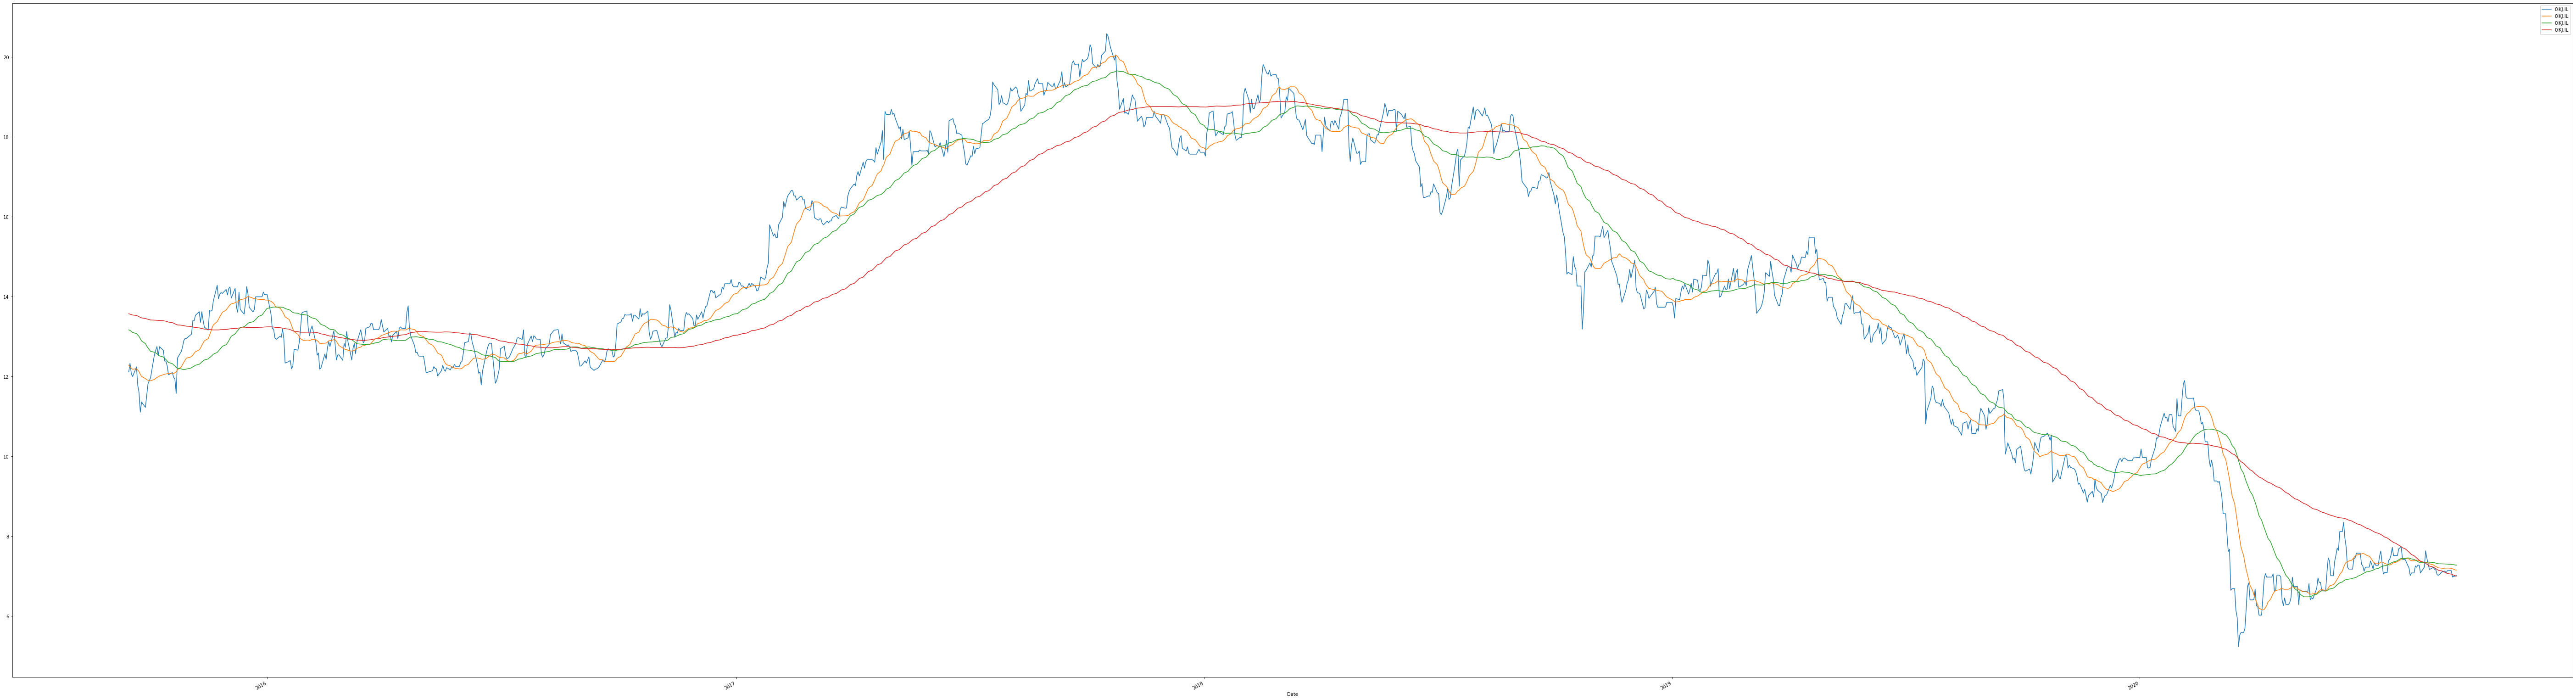

In [220]:
fig, ax = plt.subplots(1,1)
df.loc[five_yrs_ago_date:]['0IKJ.IL'].plot(figsize=(100,30), legend=True, ax=ax)
df_20MA.loc[five_yrs_ago_date:]['0IKJ.IL'].plot(figsize=(100,30), legend=True, ax=ax)
df_50MA.loc[five_yrs_ago_date:]['0IKJ.IL'].plot(figsize=(100,30), legend=True, ax=ax)
df_150MA.loc[five_yrs_ago_date:]['0IKJ.IL'].plot(figsize=(100,30), legend=True, ax=ax)

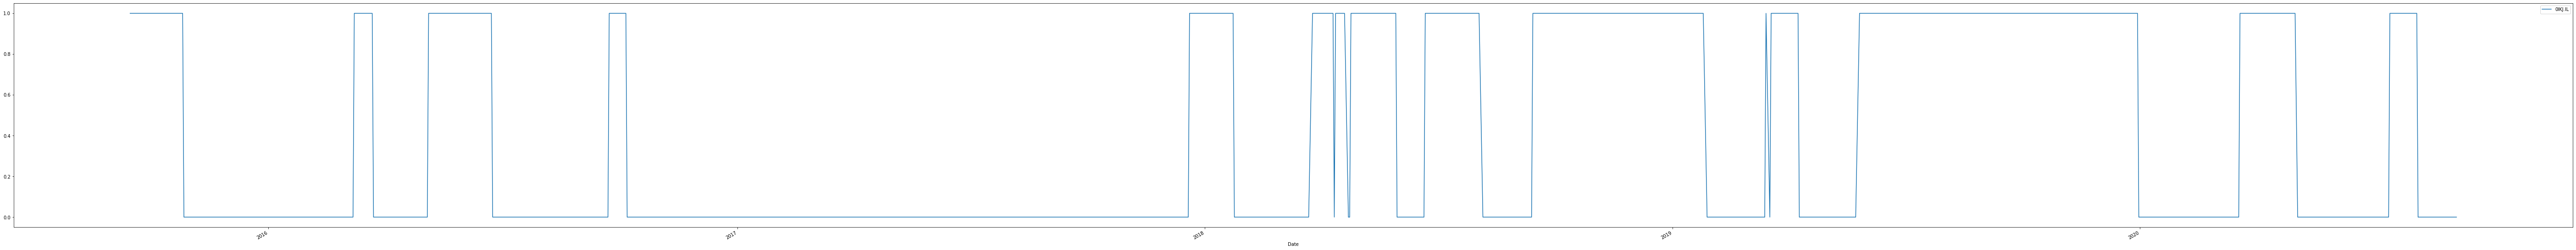

In [221]:
short_holdings['0IKJ.IL'].plot(figsize=(100,10), legend=True)

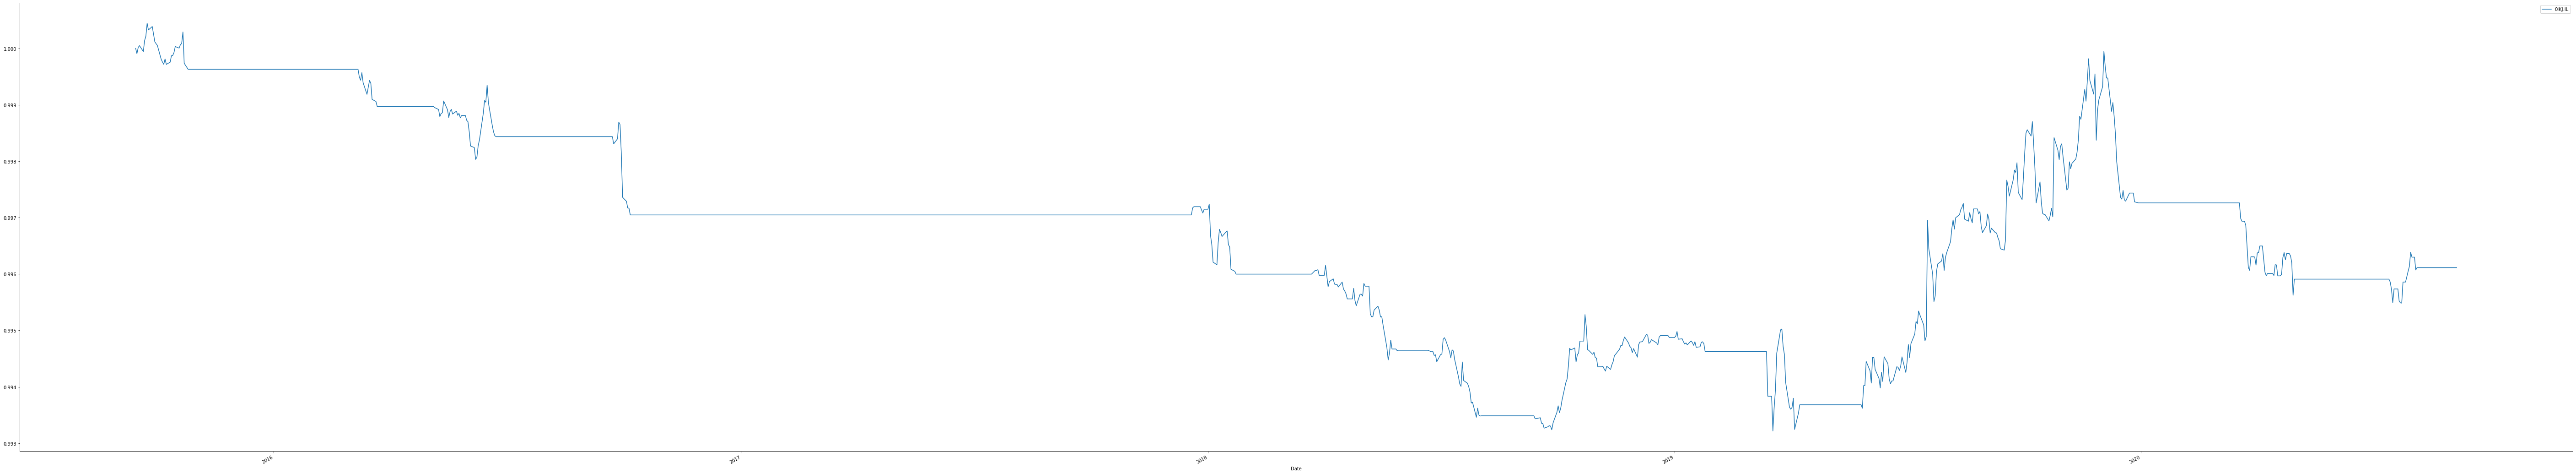

In [222]:
((-1*short_holdings.mul(short_w, axis='index')*ret_df)['0IKJ.IL'] + 1).cumprod().plot(figsize=(100,20), legend=True)

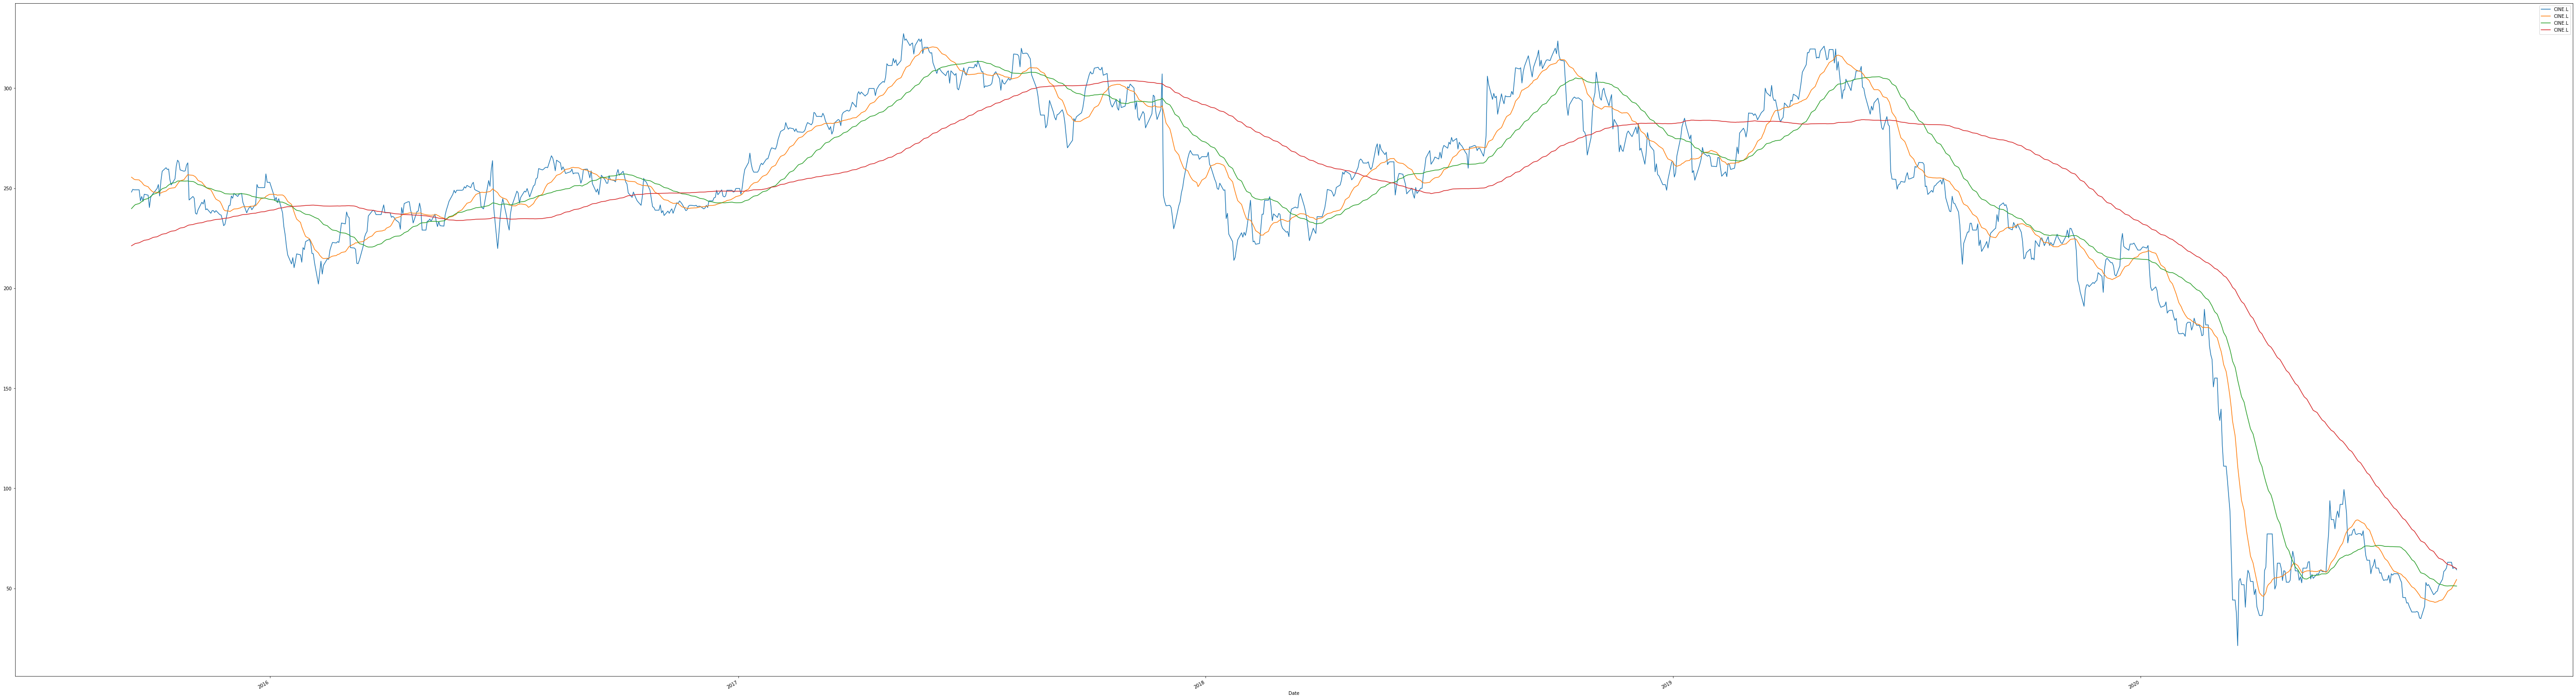

In [223]:
fig, ax = plt.subplots(1,1)
df.loc[five_yrs_ago_date:]['CINE.L'].plot(figsize=(100,30), legend=True, ax=ax)
df_20MA.loc[five_yrs_ago_date:]['CINE.L'].plot(figsize=(100,30), legend=True, ax=ax)
df_50MA.loc[five_yrs_ago_date:]['CINE.L'].plot(figsize=(100,30), legend=True, ax=ax)
df_150MA.loc[five_yrs_ago_date:]['CINE.L'].plot(figsize=(100,30), legend=True, ax=ax)

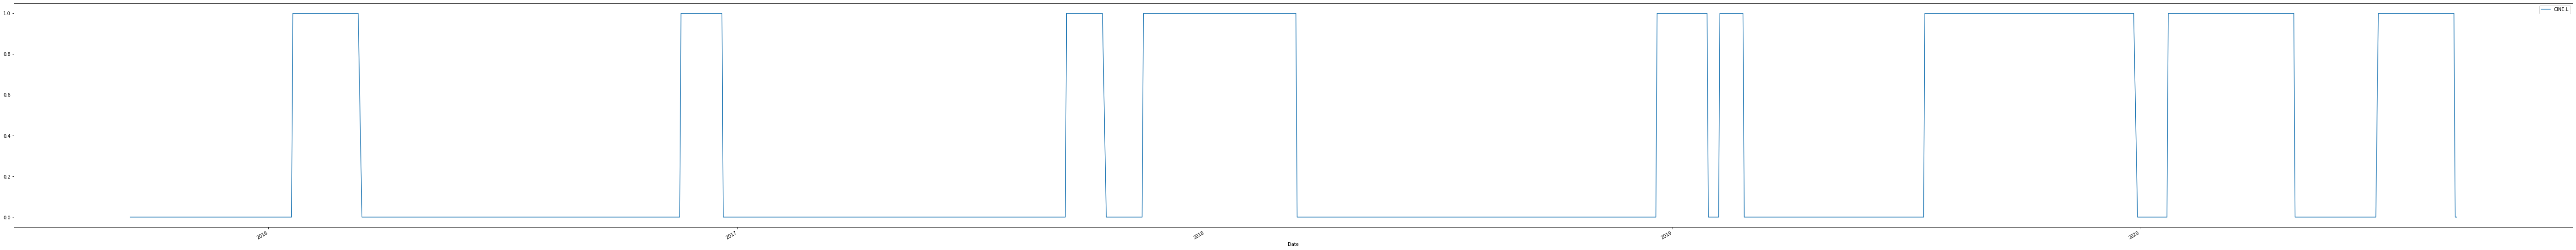

In [224]:
short_holdings['CINE.L'].plot(figsize=(100,10), legend=True)

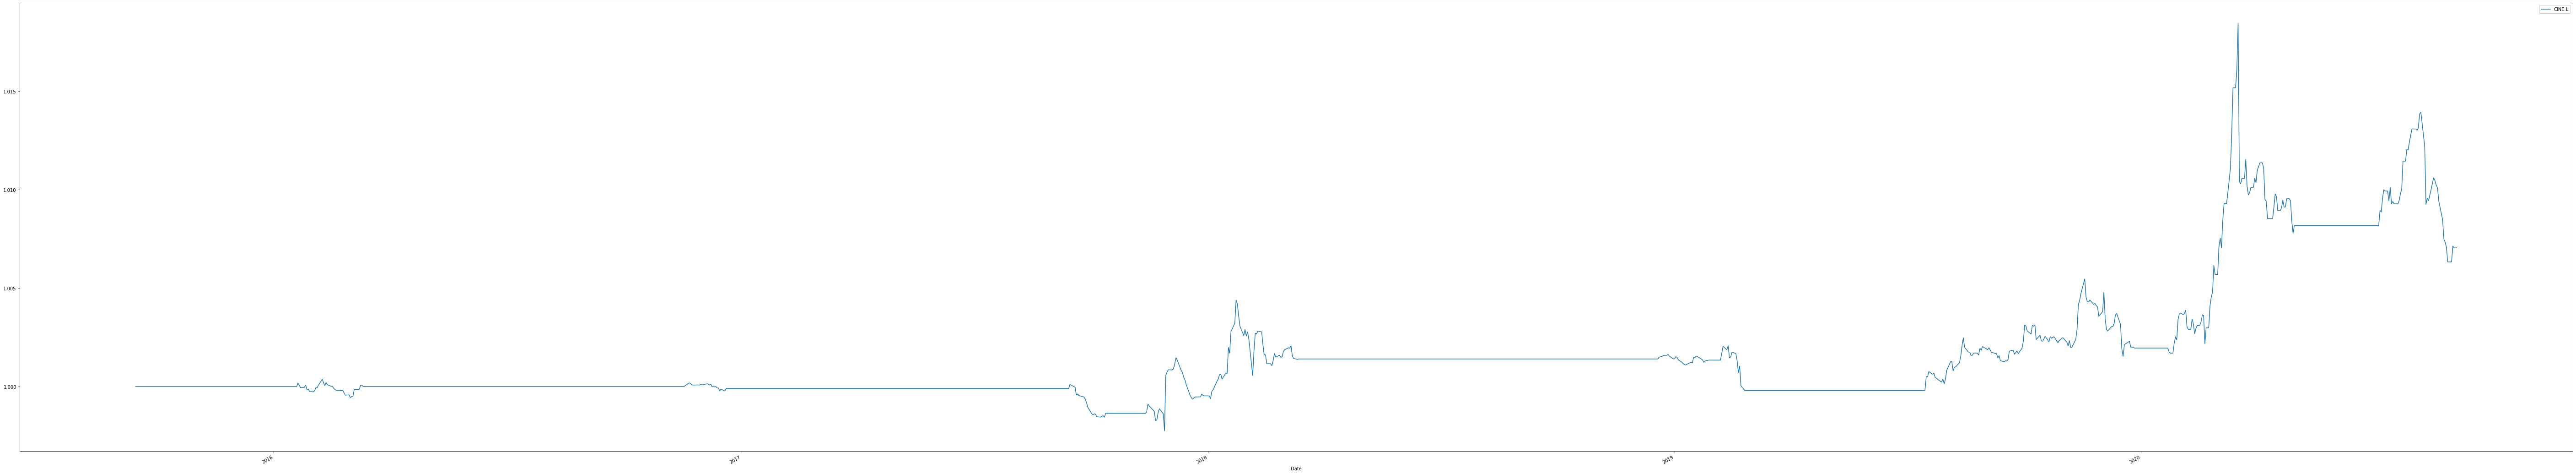

In [225]:
((-1*short_holdings.mul(short_w, axis='index')*ret_df)['CINE.L'] + 1).cumprod().plot(figsize=(100,20), legend=True)

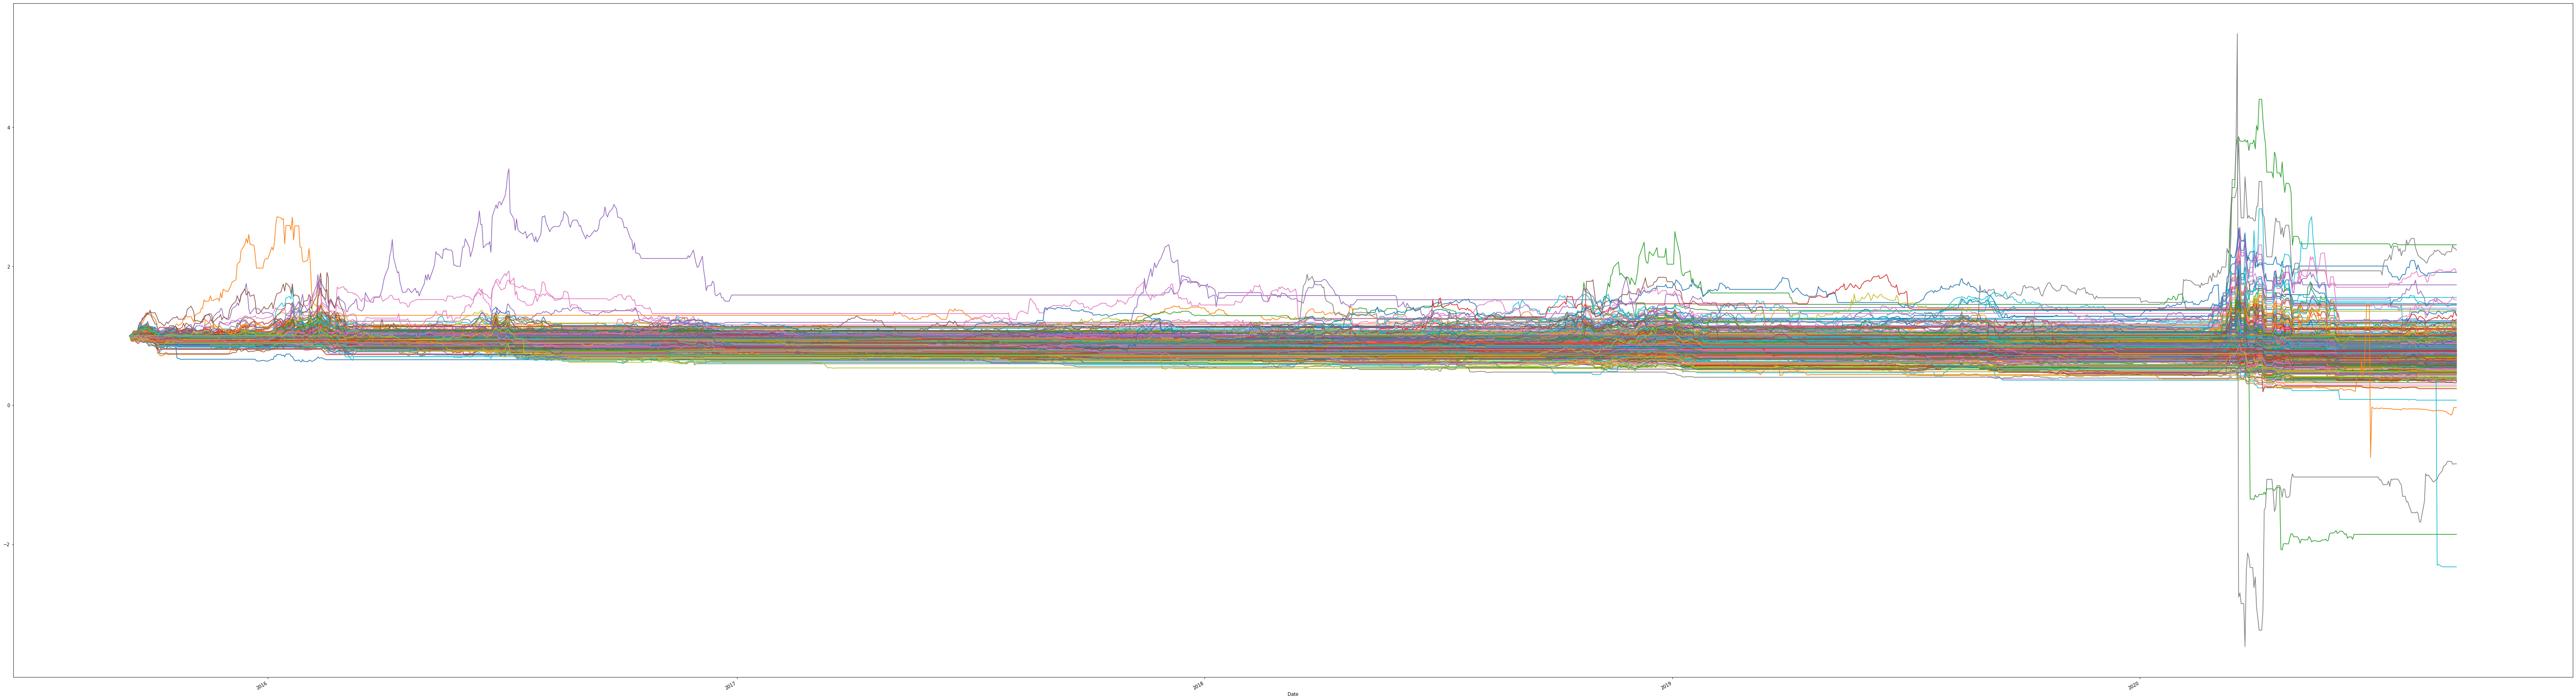

In [226]:
sth = (1+ (-1*short_holdings*ret_df)).cumprod()
sth.plot(figsize=(100,30), legend=False)

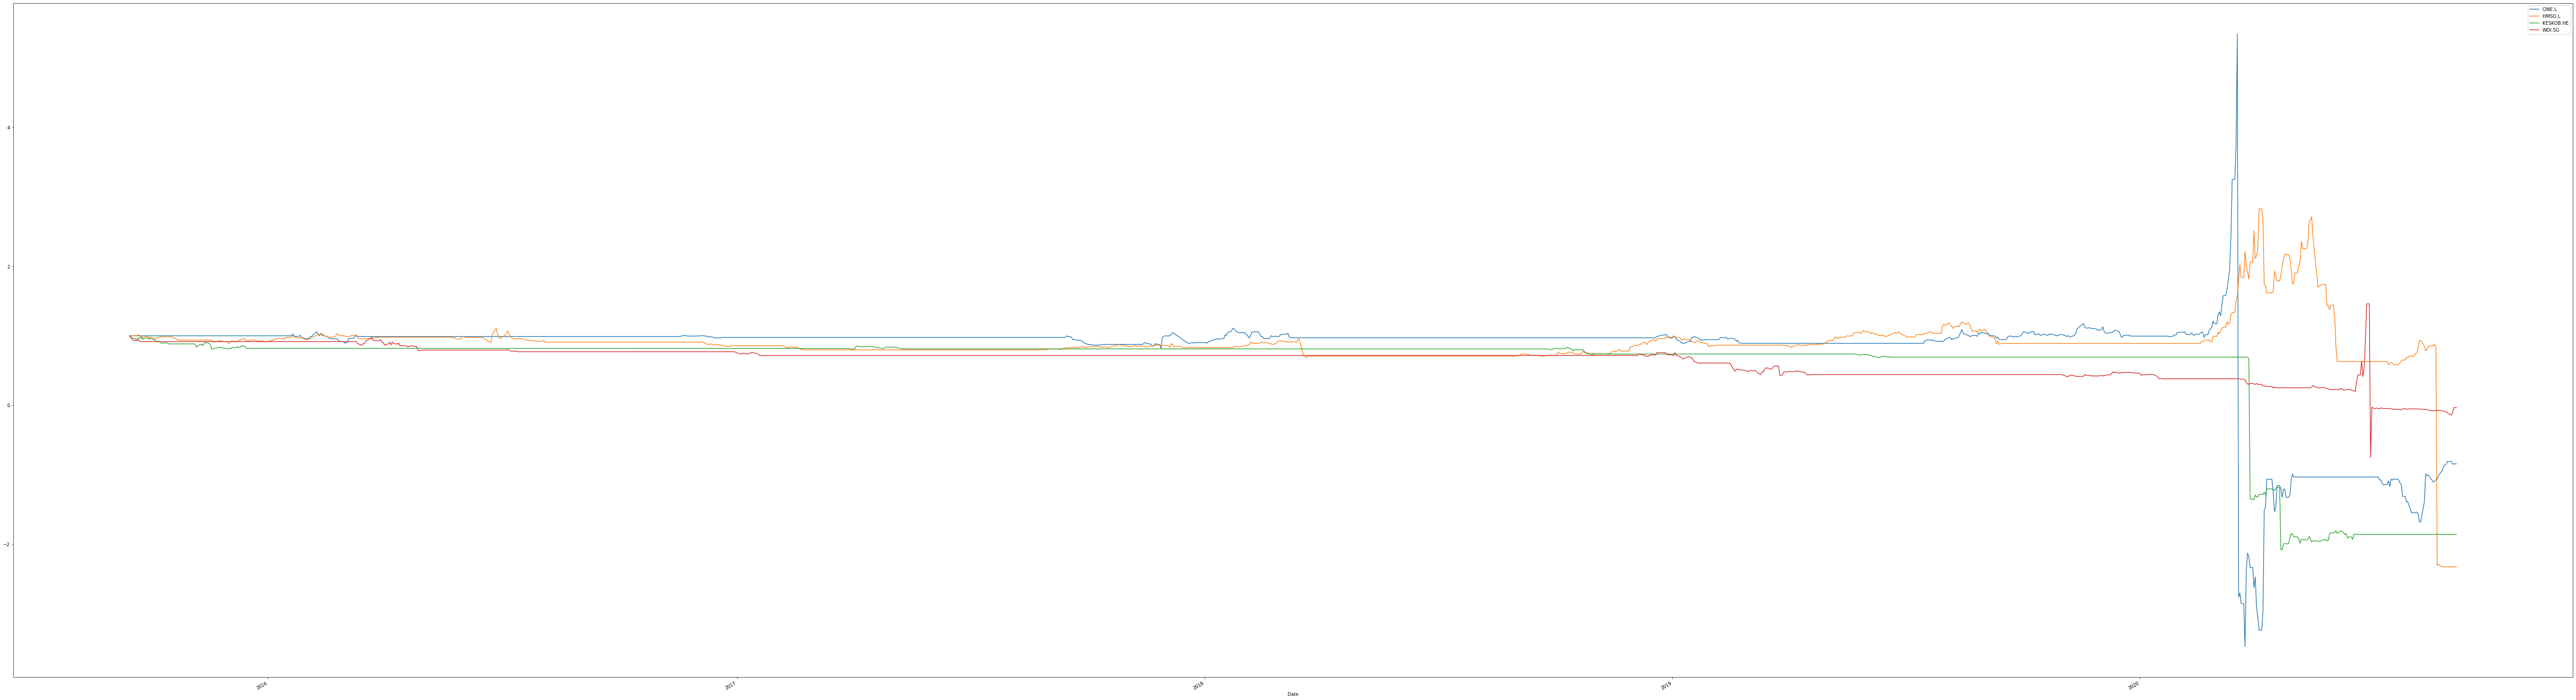

In [227]:
sth[short_cols].plot(figsize=(100,30), legend=True)

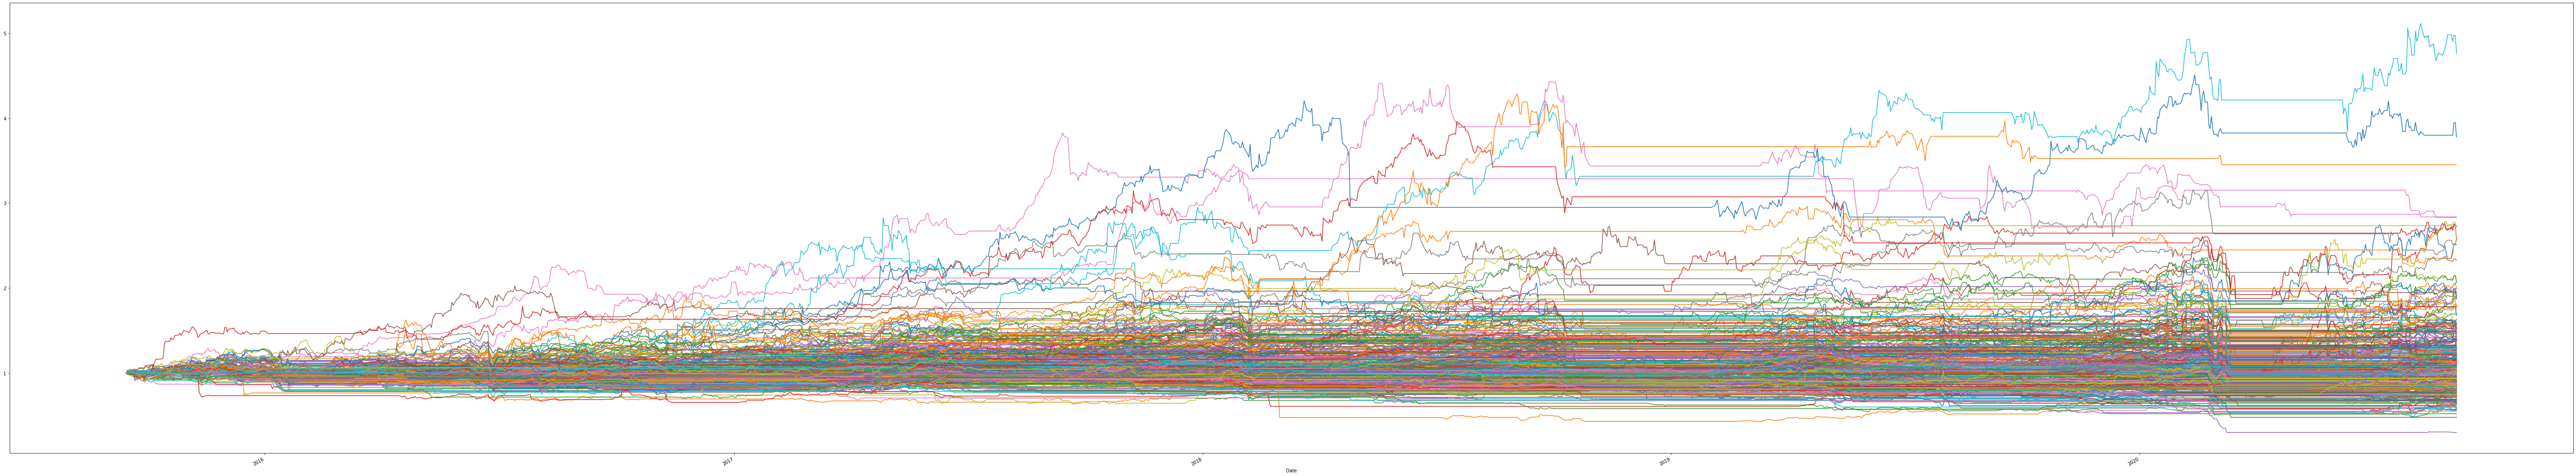

In [228]:
(1 + (long_holdings*ret_df)).cumprod().plot(figsize=(100,20), legend=False)

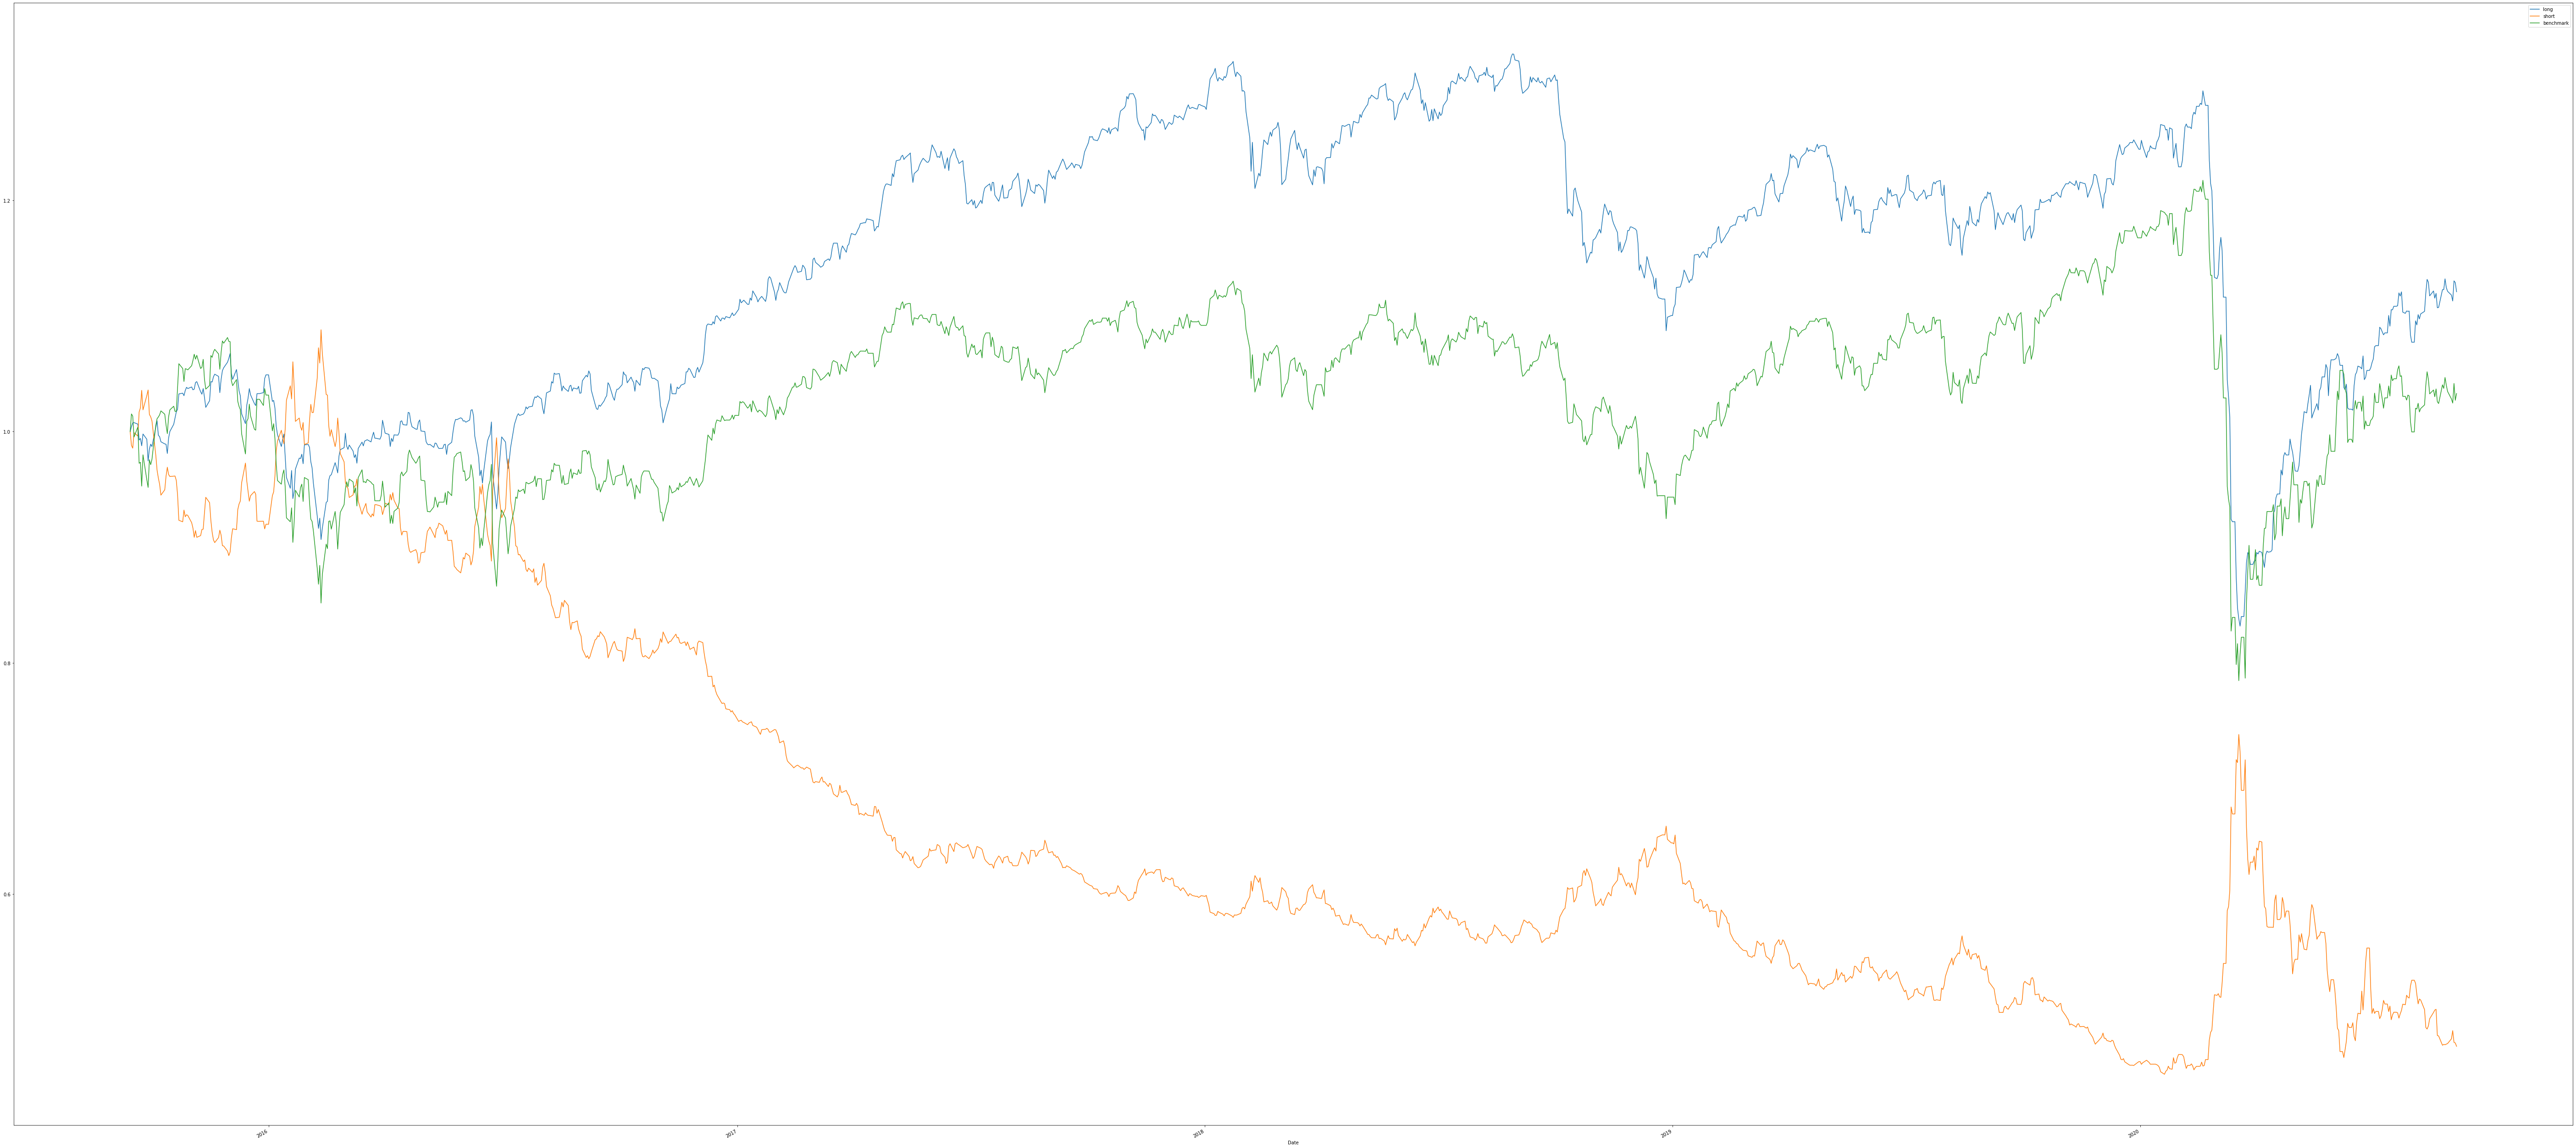

In [229]:
## Long/ Short Side Plot
ew_eq_curve.plot(figsize=(100,50), legend=True) #.loc['2020-08-01':]
plt.show()
plt.close()

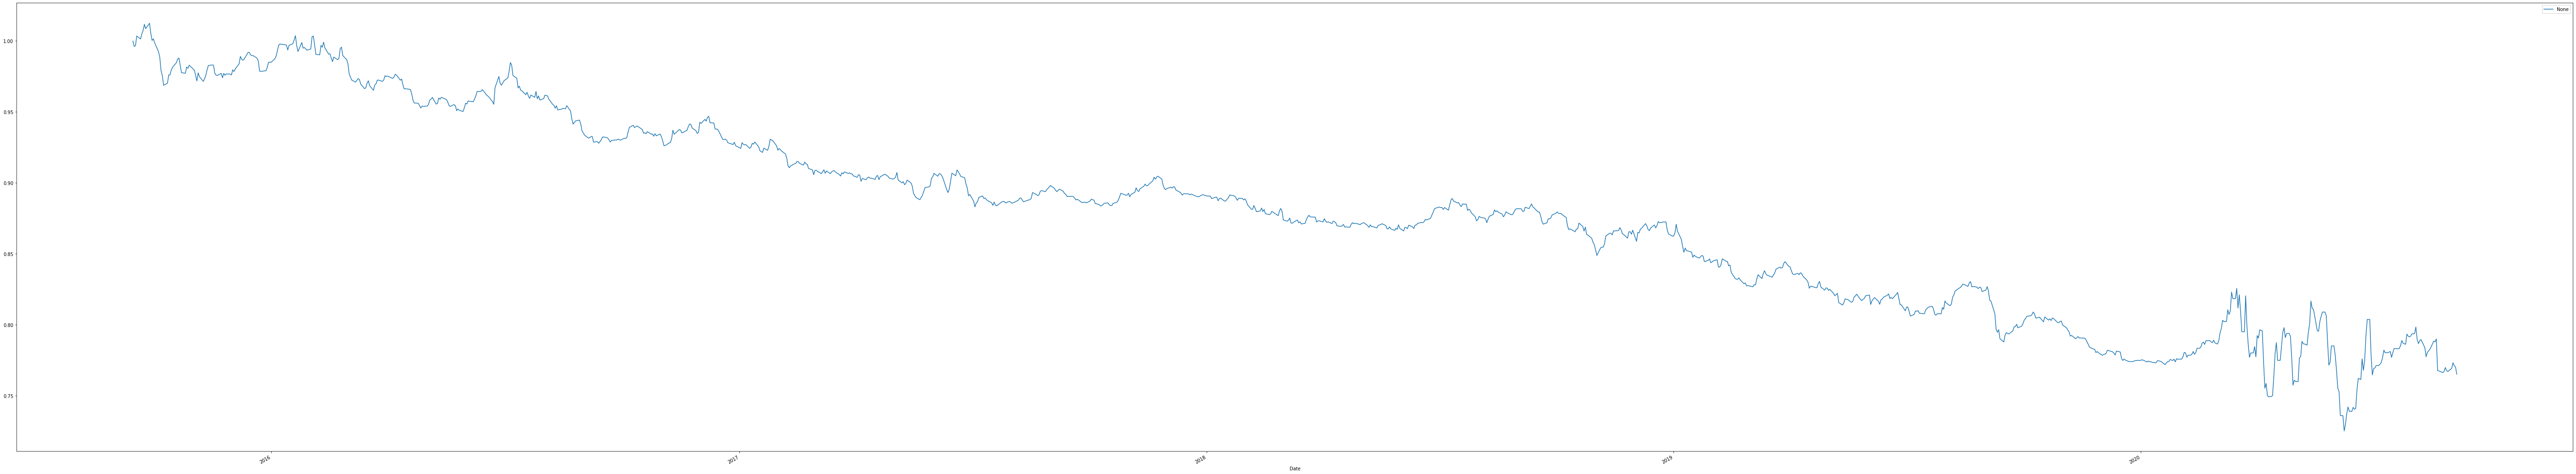

In [230]:
## combined PnL

combined_PnL = (0.5*port_ret['long'] + 0.5*port_ret['short'] + 1).cumprod()
combined_PnL.plot(figsize=(100,20), legend=True)

plt.show()
plt.close()

In [231]:
combined_PnL.pct_change(1).skew()

-0.7010031931954918

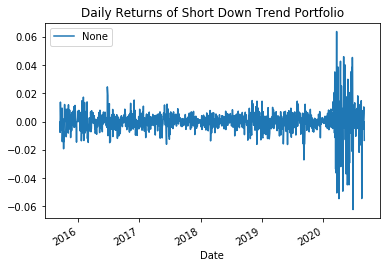

Ending Equity/ Profitability
Date
2020-09-04    0.969463
dtype: float64
count    1326.000000
mean        0.000015
std         0.008722
min        -0.062242
25%        -0.002903
50%         0.000014
75%         0.003475
max         0.063728
dtype: float64


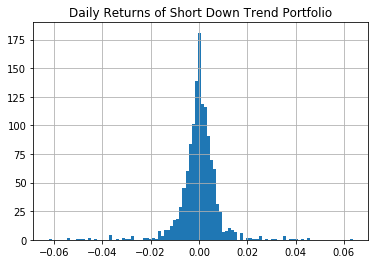

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     272.1
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           9.77e-56
Time:                        09:32:18   Log-Likelihood:                 4530.7
No. Observations:                1326   AIC:                            -9057.
Df Residuals:                    1324   BIC:                            -9047.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.463e-05      0.000

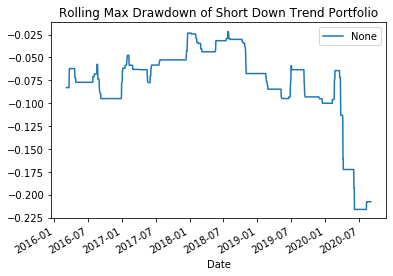

max dd: -0.21600943049320176
IR
Date
2015-12-31         NaN
2016-12-31   -0.193538
2017-12-31   -1.740225
2018-12-31    6.357643
2019-12-31   -8.097907
2020-12-31    3.068127
Freq: A-DEC, dtype: float64
-0.12118004609573445
Profit       0.969463
Alpha        0.000045
Beta        -0.330903
Daily Vol    0.008722
MaxDD       -0.216009
IR          -0.121180
dtype: float64


Profit       0.969463
Alpha        0.000045
Beta        -0.330903
Daily Vol    0.008722
MaxDD       -0.216009
IR          -0.121180
dtype: float64

In [217]:
performance_analysis(combined_PnL, (port_ret['benchmark'] + 1).cumprod(), port_name="Short Down Trend Portfolio")

## END FOR NOW ##

will come back for continuous signals or different weighting scheme than equal weighting later

In [13]:
## what if we seperate the two trend trading rules, what the portfolio will look like?
signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA - df_150MA


holdings_20_50 = np.sign(signal_20_50).replace(-1, 0)[five_yrs_ago_date:]
holdings_50_150 = np.sign(signal_50_150).replace(-1, 0)[five_yrs_ago_date:]

w_20_50 = (1/holdings_20_50.sum(axis=1)).replace([np.inf, -np.inf], 0)
w_50_150 = (1/holdings_50_150.sum(axis=1)).replace([np.inf, -np.inf], 0)


arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)


port_ret_20_50 = ((ret_df*holdings_20_50.mul(w, axis='index')).sum(axis=1) - ret_stoxx600 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
port_ret_50_150 = ((ret_df*holdings_50_150.mul(w, axis='index')).sum(axis=1) - ret_stoxx600 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
            
            
ew_eq_curve_20_50 = (port_ret_20_50+1).cumprod()
ew_eq_curve_50_150 = (port_ret_50_150+1).cumprod()


In [14]:
len([0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5))

1333

In [15]:
ew_eq_curve_20_50_150 = ew_eq_curve_20_50.rename('20_50').to_frame()
ew_eq_curve_20_50_150['50_150'] = ew_eq_curve_50_150
ew_eq_curve_20_50_150["original"] = combined_PnL


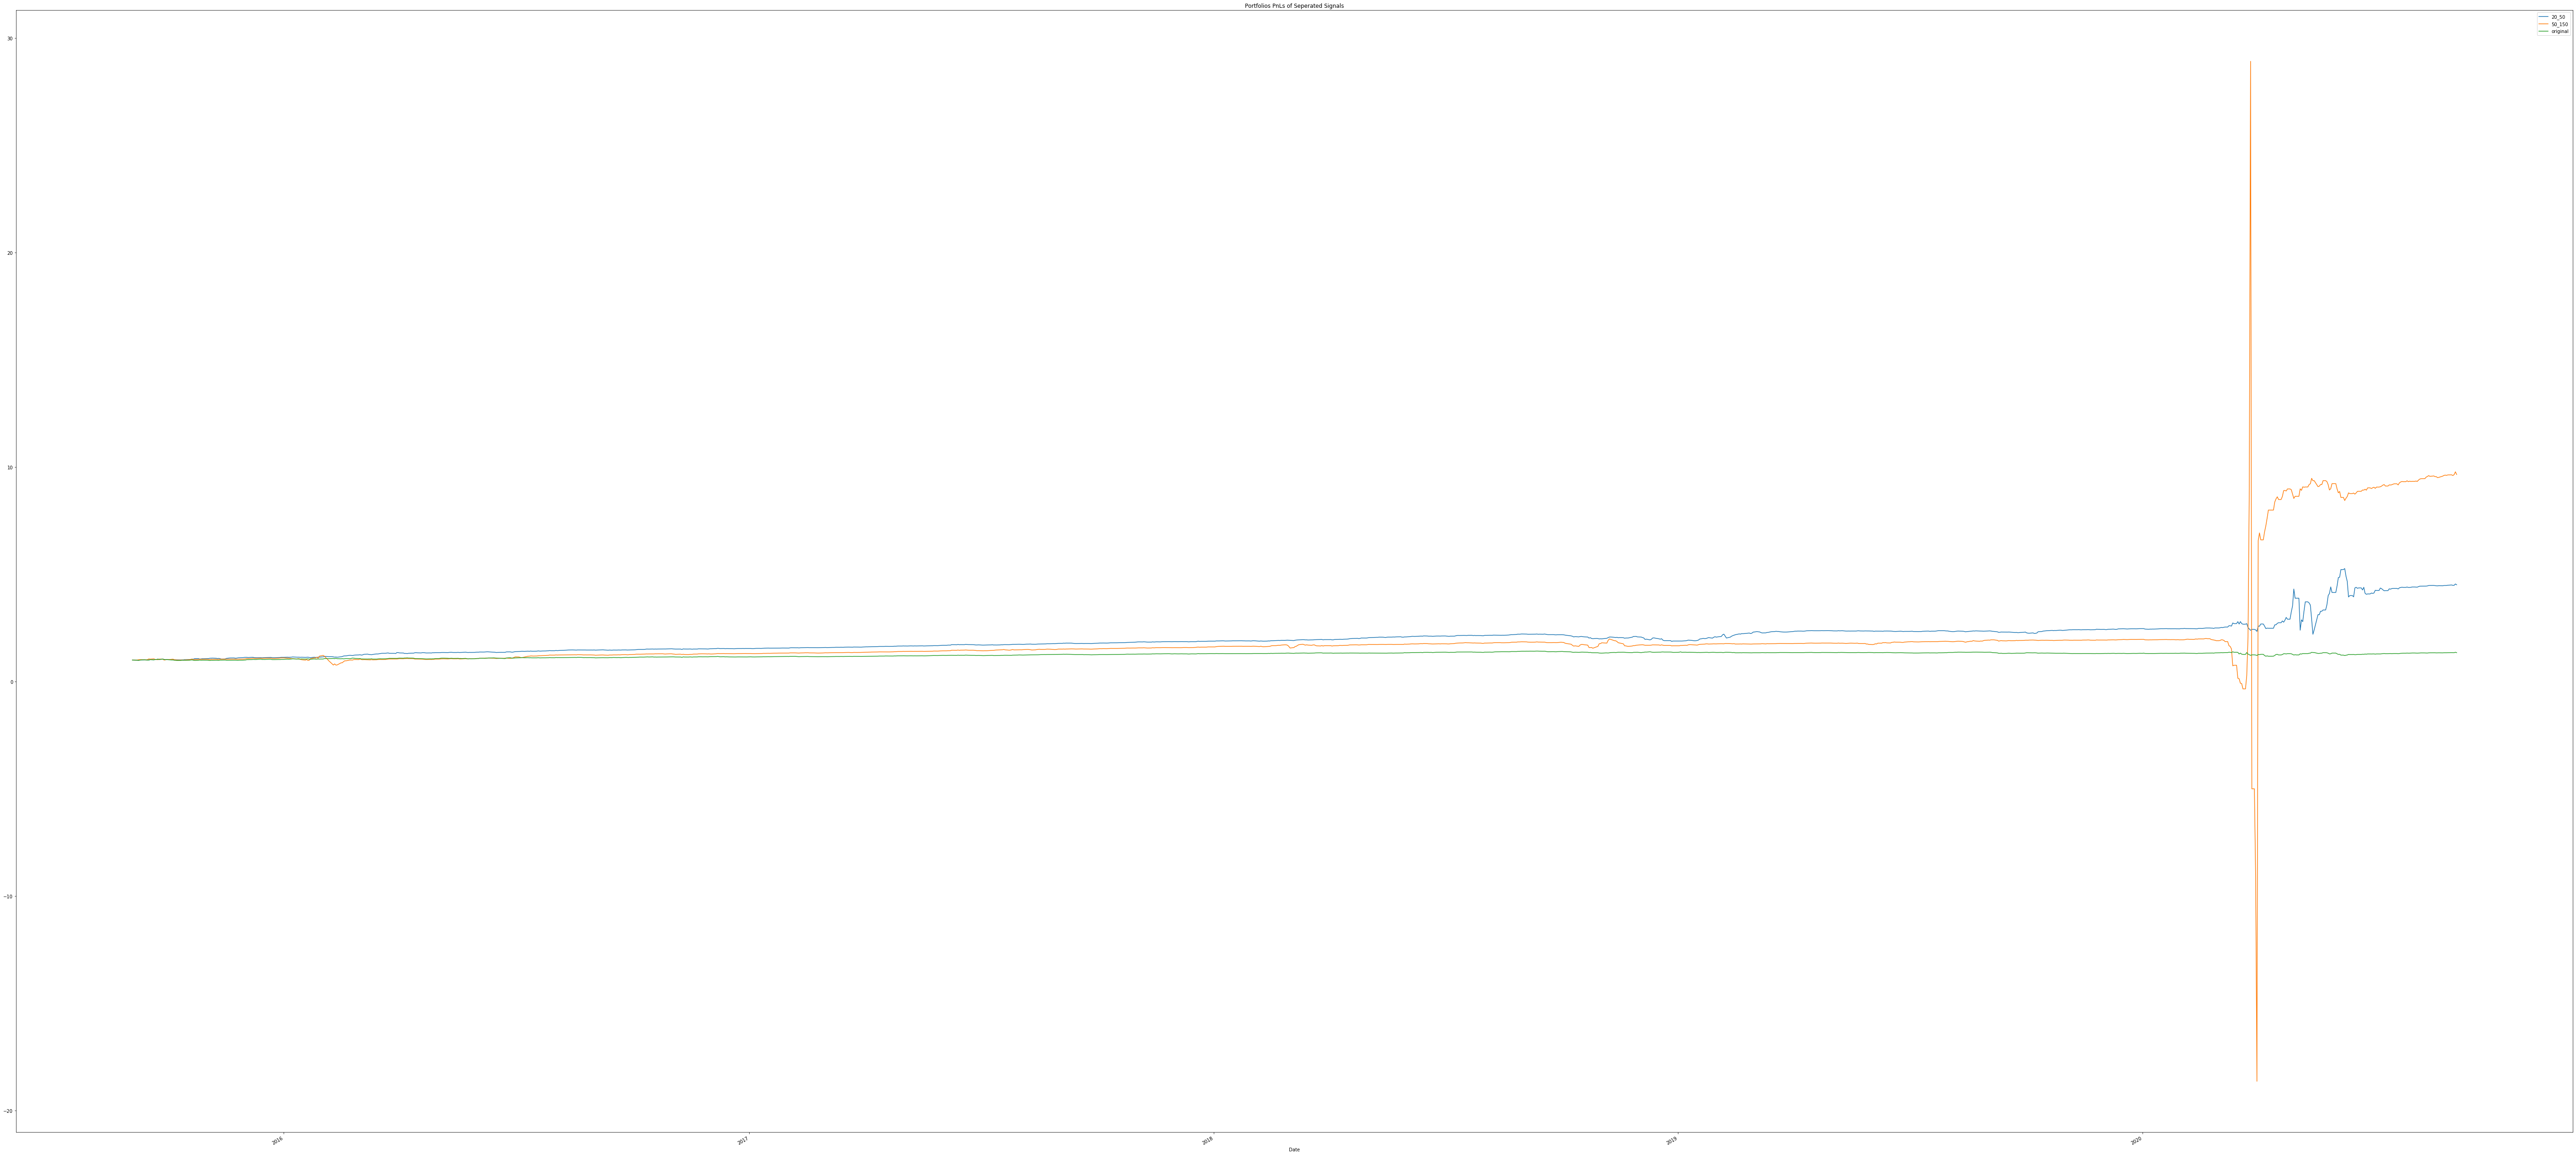

In [16]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Seperated Signals")
plt.show()
plt.close()


We also discovered a most likely data quality issue, from yahoo finance
seems like two decimal points are missing for CRDA.L
We'll edit it for now and rerun previous analysis







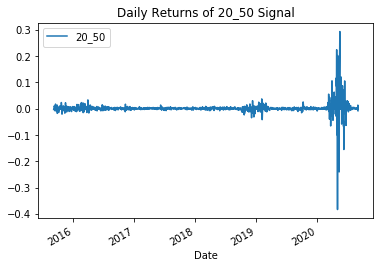

Ending Equity/ Profitability
Date
2020-09-04    4.512553
Name: 20_50, dtype: float64
count    1332.000000
mean        0.001407
std         0.022810
min        -0.383904
25%        -0.001621
50%         0.000430
75%         0.003462
max         0.293769
Name: 20_50, dtype: float64


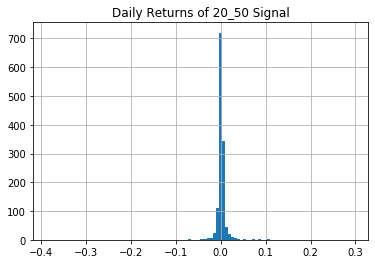

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     47.17
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           9.94e-12
Time:                        11:49:25   Log-Likelihood:                 3169.4
No. Observations:                1332   AIC:                            -6335.
Df Residuals:                    1330   BIC:                            -6324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001

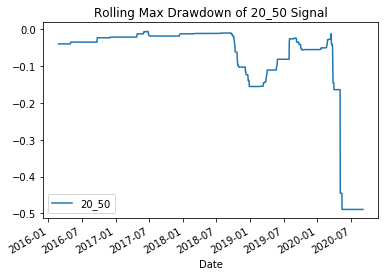

max dd: -0.48898418959491163
IR
Date
2015-12-31         NaN
2016-12-31    2.183349
2017-12-31    7.836438
2018-12-31    2.367748
2019-12-31    2.055186
2020-12-31    0.186078
Freq: A-DEC, dtype: float64
2.925759770641731
Profit       4.512553
Alpha        0.001371
Beta         0.388039
Daily Vol    0.022810
MaxDD       -0.488984
IR           2.925760
dtype: float64


Profit       4.512553
Alpha        0.001371
Beta         0.388039
Daily Vol    0.022810
MaxDD       -0.488984
IR           2.925760
dtype: float64

In [17]:
performance_analysis(ew_eq_curve_20_50_150['20_50'], (port_ret['Short'] + 1).cumprod(), port_name="20_50 Signal")


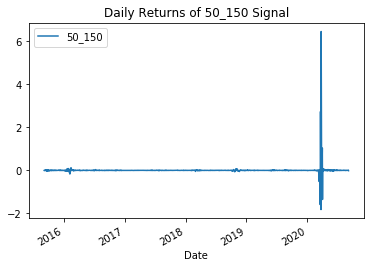

Ending Equity/ Profitability
Date
2020-09-04    9.651476
Name: 50_150, dtype: float64
count    1332.000000
mean        0.007746
std         0.240545
min        -1.821810
25%        -0.001914
50%         0.000320
75%         0.003438
max         6.460714
Name: 50_150, dtype: float64


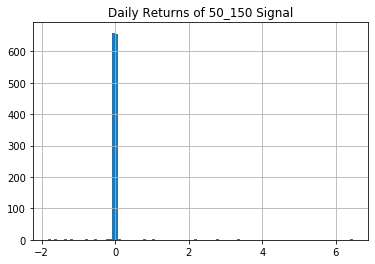

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     162.4
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           3.49e-35
Time:                        11:49:27   Log-Likelihood:                 85.108
No. Observations:                1332   AIC:                            -166.2
Df Residuals:                    1330   BIC:                            -155.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.006

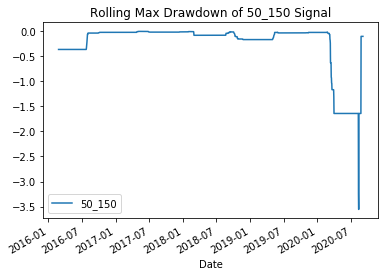

max dd: -3.5551634883195717
IR
Date
2015-12-31         NaN
2016-12-31    2.524662
2017-12-31    2.374708
2018-12-31    2.390096
2019-12-31    3.227557
2020-12-31   -0.024484
Freq: A-DEC, dtype: float64
2.0985080624758345
Profit       9.651476
Alpha        0.007082
Beta         7.293788
Daily Vol    0.240545
MaxDD       -3.555163
IR           2.098508
dtype: float64


Profit       9.651476
Alpha        0.007082
Beta         7.293788
Daily Vol    0.240545
MaxDD       -3.555163
IR           2.098508
dtype: float64

In [18]:
performance_analysis(ew_eq_curve_20_50_150['50_150'], (port_ret['Short'] + 1).cumprod(), port_name="50_150 Signal")

In [232]:
sep_signal_ret = port_ret_20_50.rename('20_50').to_frame()
sep_signal_ret['50_150'] = port_ret_50_150

NameError: name 'port_ret_20_50' is not defined

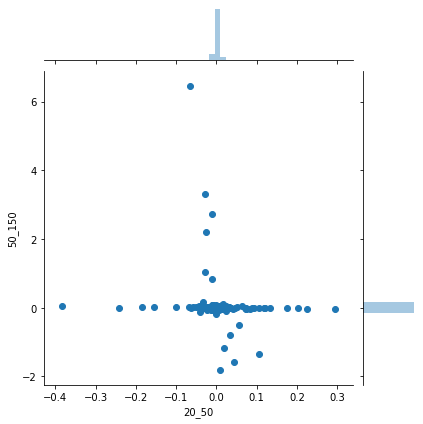

In [20]:
## The returns of the trading are plagued by outliers
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [21]:
## Can remove the outliers by winsorizing 
sep_signal_ret = pd.DataFrame(mstats.winsorize(sep_signal_ret, [0.05, 0.05]), index=sep_signal_ret.index, columns=sep_signal_ret.columns)

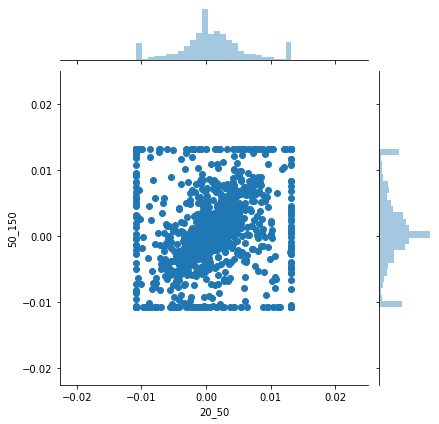

In [22]:
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [23]:
sep_signal_ret.corr()

20_50    50_150
20_50   1.000000  0.154012
50_150  0.154012  1.000000

In [24]:
def compute_MV_weights(cov_m):
    inv_covar = np.linalg.inv(cov_m)
    u = np.ones(len(cov_m))
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))

In [25]:
## adjust by price volatility, so big moves of slow movers weight more than big moves of big movers
std_df = ret_df.rolling(60).std()
price_vol = df*std_df

In [26]:
## try to build different portfolios to see if there's improvement with different weighting scheme


signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA -df_150MA

norm_signal_20_50 = ((signal_20_50)/price_vol).replace([np.inf, -np.inf, np.nan],0)
norm_signal_50_150 = ((signal_50_150)/price_vol).replace([np.inf, -np.inf, np.nan],0)

## we can weight the two signals by inversing the covariance matrix of the seperated portfolio returns, will ignore insample calculation for now


w_trading_rules = compute_MV_weights(sep_signal_ret.cov())
w_trading_rules

array([0.52981934, 0.47018066])

In [27]:
combined_signal = norm_signal_20_50*w_trading_rules[0] + norm_signal_50_150*w_trading_rules[1]

In [28]:
combined_signal.describe()

0GRX.IL      0GWL.IL      0GZV.IL      0H13.IL      0H7O.IL  \
count  1594.000000  1594.000000  1594.000000  1594.000000  1594.000000   
mean      0.879474     0.420458    -0.350015     0.841004    -0.326574   
std       1.842246     2.848245     2.943250     2.561773     2.497034   
min      -4.488640   -10.038197    -8.968333    -5.073636   -10.765223   
25%       0.000000    -1.211363    -2.101546    -0.610618    -1.421574   
50%       0.889005     0.000000     0.000000     0.000000     0.000000   
75%       2.196591     2.120401     1.348166     2.191631     0.822992   
max       5.595990     7.632037     7.262148     9.769487     5.418083   

           0HAU.IL      0HBT.IL      0IAH.IL      0IKJ.IL      0IXZ.IL  ...  \
count  1594.000000  1594.000000  1594.000000  1594.000000  1594.000000  ...   
mean      1.409700     0.186420     0.256221    -0.370720    -0.488229  ...   
std       2.461860     2.417337     1.937347     2.401120     2.486925  ...   
min      -3.904415    -6.383441    -9.169064    -7.025668    -7.496525  ...   
25%       0.000000    -1.251548    -0.461850    -1.822142    -2.177710  ...   
50%       0.828262     0.000000     0.000000     0.000000     0.000000  ...   
75%       3.107153     1.644593     1.513110     0.395773     0.874626  ...   
max       8.336618     6.113955     4.177348     6.927627     5.316708  ...   

            VWS.CO       WDI.SG       WIB.BE       WKL.AS       WO6.BE  \
count  1594.000000  1594.000000  1594.000000  1594.000000  1594.000000   
mean      0.796344    -1.410616     0.398023     1.598155     1.960322   
std       2.301242    13.859442     2.039276     2.154061     5.654617   
min      -6.358472  -150.664700    -8.211283    -3.452984    -2.239508   
25%      -0.527308    -0.660942    -0.385161     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     1.044655     0.000000   
75%       2.623088     2.743203     1.416247     3.236722     0.519746   
max       6.223631     9.404402     5.350006     7.354007    43.057508   

             WPP.L        WTB.L       YAR.OL       ZAL.DE      ZFIN.SG  
count  1594.000000  1594.000000  1594.000000  1594.000000  1594.000000  
mean     -0.763708    -0.622374    -0.046377     0.464365     0.831332  
std       2.563441     1.883727     2.030828     2.626387     8.045134  
min     -10.303605    -8.841294    -5.529214   -10.457414    -4.889396  
25%      -2.038383    -1.808261    -1.226306     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.377746     0.000000  
75%       0.871703     0.405136     0.993505     2.154206     1.250709  
max       3.819384     3.221942     6.521426     5.853193   310.469424  

[8 rows x 370 columns]

In [29]:
def simple_ew_backtester(bt_signal_df, bt_ret_df, b_ret, rules=0, transaction_cost=transaction_cost):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).fillna(0)

    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    bt_w = (1/bt_holdings.sum(axis=1)).replace([np.inf, -np.inf], 0)


    arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)
    
    
    
    bt_port_ret = (bt_ret_df*holdings.mul(bt_w, axis='index')).sum(axis=1) - b_ret - pd.Series(arr_transaction_cost, index=w.index)
    bt_ew_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_ew_eq_curve
    
    
    
    
    

In [30]:
combined_ew_ret_0, combined_ew_eq_curve_0 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=0, transaction_cost=transaction_cost)
combined_ew_ret_1, combined_ew_eq_curve_1 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=1, transaction_cost=transaction_cost)
combined_ew_ret_2, combined_ew_eq_curve_2 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=2, transaction_cost=transaction_cost)

In [31]:

ew_eq_curve_20_50_150['ew_mv_signal_0'] = combined_ew_eq_curve_0
ew_eq_curve_20_50_150['ew_mv_signal_1'] = combined_ew_eq_curve_1
ew_eq_curve_20_50_150['ew_mv_signal_2'] = combined_ew_eq_curve_2

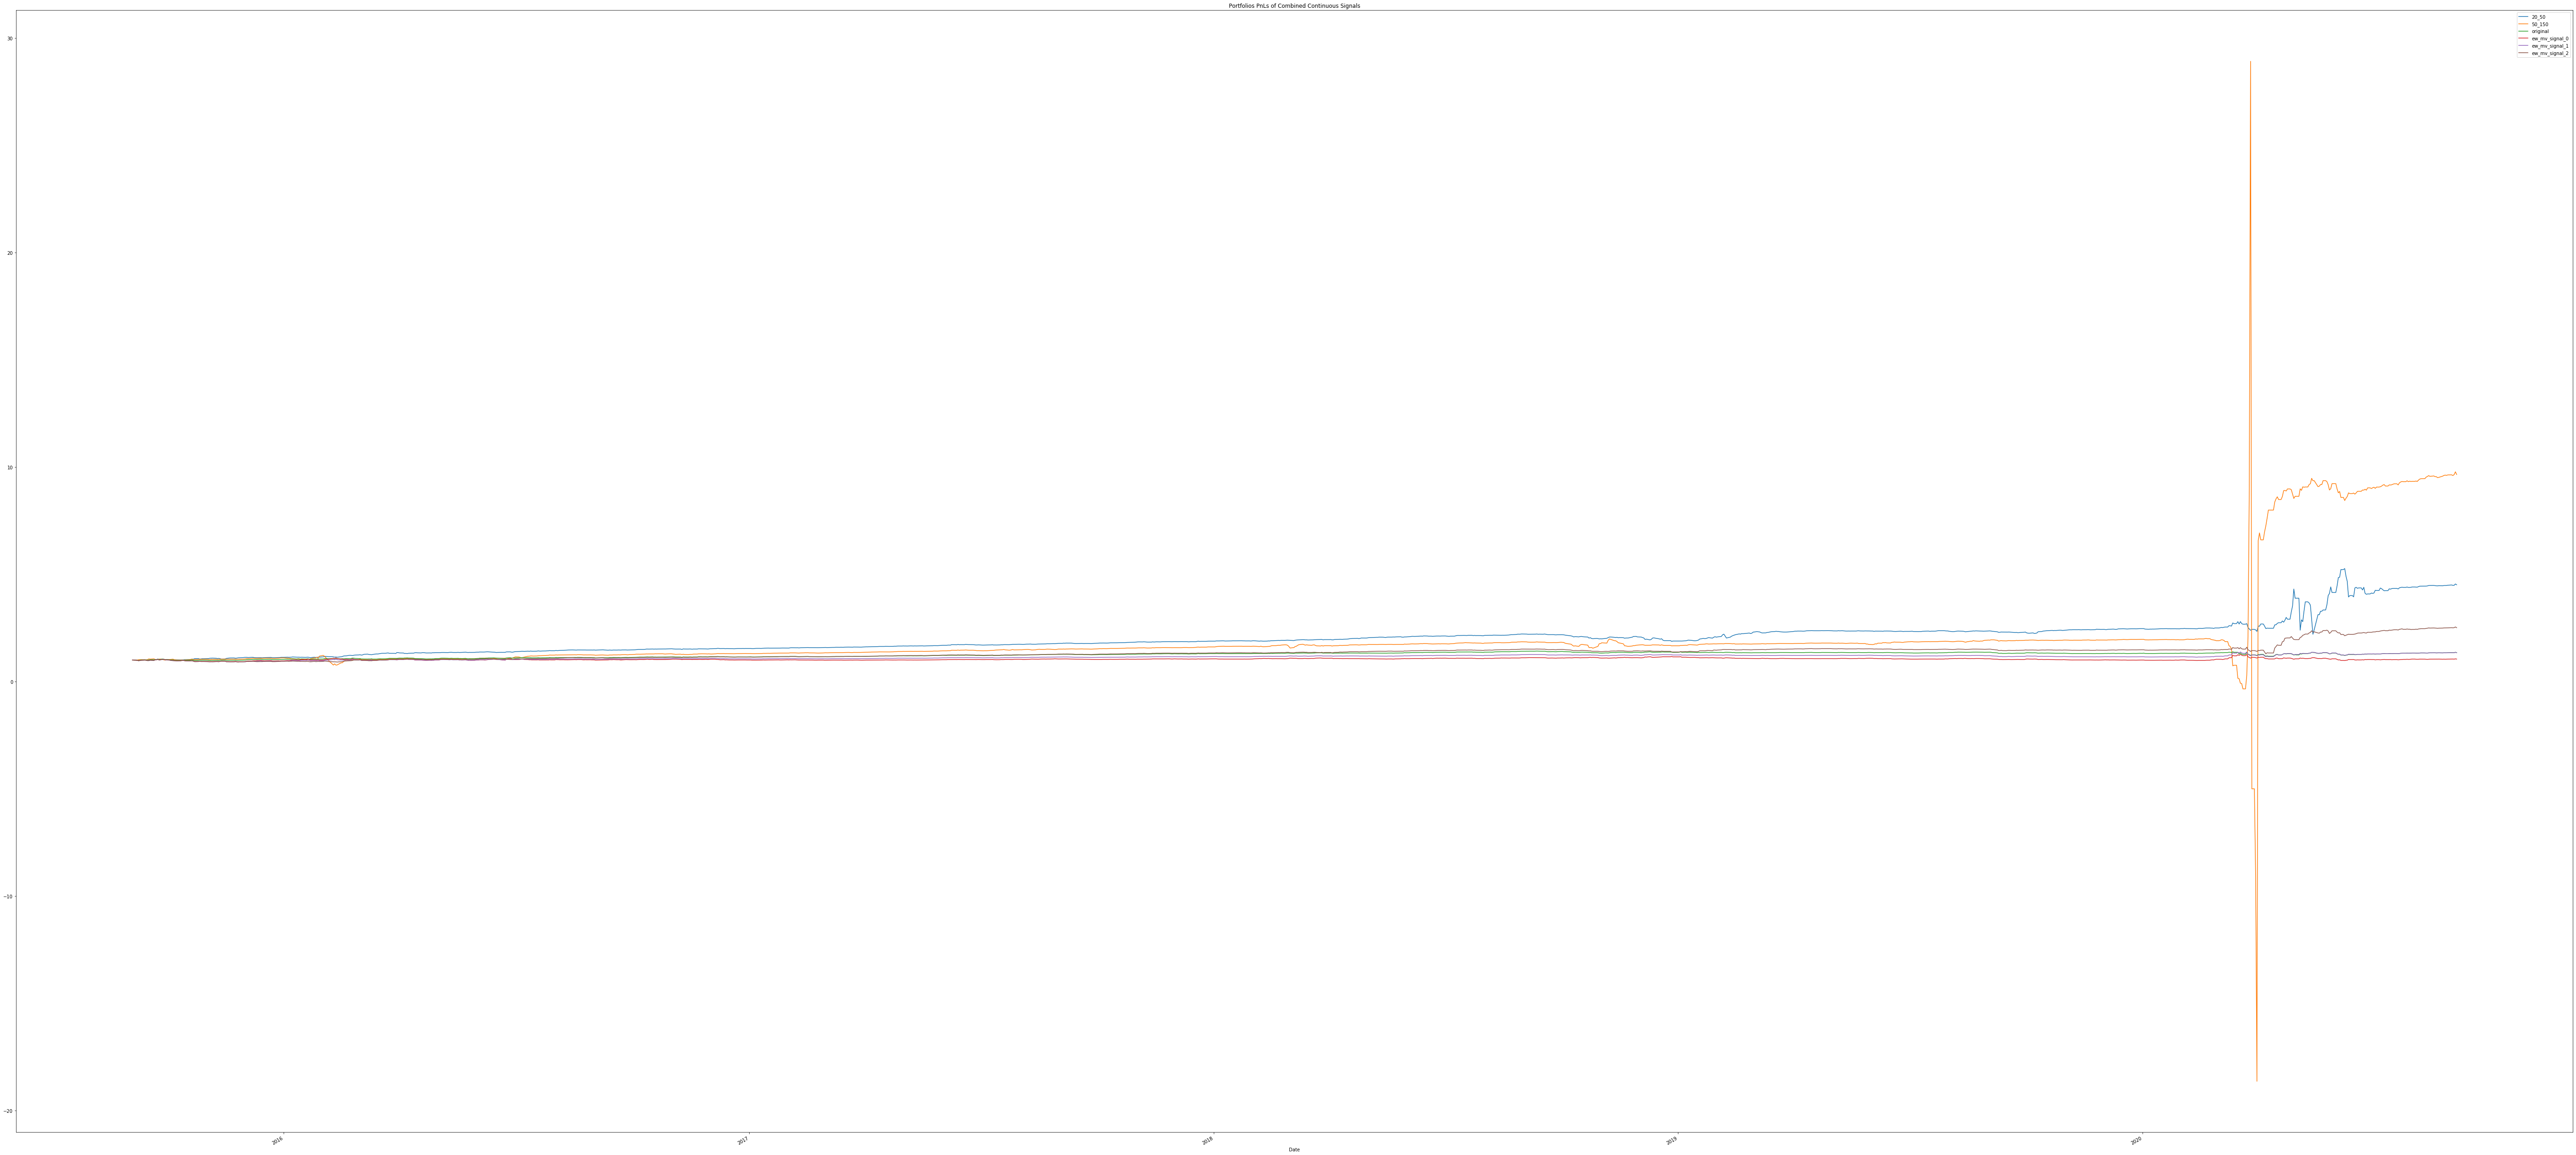

In [32]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Combined Continuous Signals")
plt.show()
plt.close()

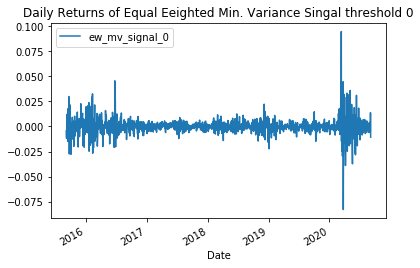

Ending Equity/ Profitability
Date
2020-09-04    1.048012
Name: ew_mv_signal_0, dtype: float64
count    1332.000000
mean        0.000070
std         0.008311
min        -0.082971
25%        -0.002791
50%         0.000000
75%         0.002848
max         0.094833
Name: ew_mv_signal_0, dtype: float64


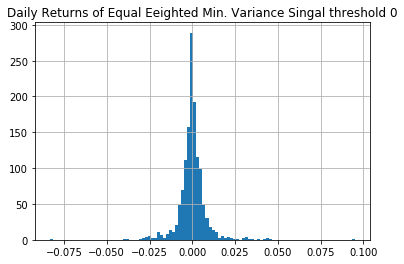

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 1.089e+04
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:49:33   Log-Likelihood:                 5968.4
No. Observations:                1332   AIC:                        -1.193e+04
Df Residuals:                    1330   BIC:                        -1.192e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   7.51e-05

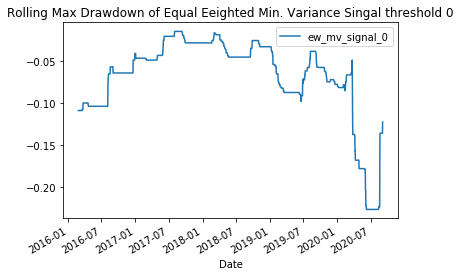

max dd: -0.22609641075714149
IR
Date
2015-12-31         NaN
2016-12-31   -1.992857
2017-12-31    2.261255
2018-12-31   -1.306490
2019-12-31    4.302553
2020-12-31   -6.297199
Freq: A-DEC, dtype: float64
-0.6065474656601506
Profit       1.048012
Alpha        0.000135
Beta        -0.721112
Daily Vol    0.008311
MaxDD       -0.226096
IR          -0.606547
dtype: float64


Profit       1.048012
Alpha        0.000135
Beta        -0.721112
Daily Vol    0.008311
MaxDD       -0.226096
IR          -0.606547
dtype: float64

In [33]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_0'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 0")

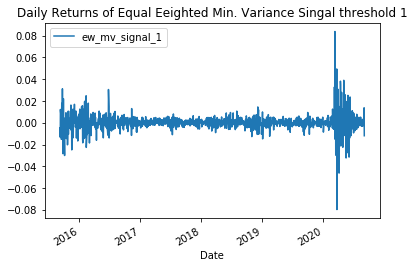

Ending Equity/ Profitability
Date
2020-09-04    1.345737
Name: ew_mv_signal_1, dtype: float64
count    1332.000000
mean        0.000252
std         0.007581
min        -0.079735
25%        -0.002166
50%         0.000000
75%         0.002688
max         0.083801
Name: ew_mv_signal_1, dtype: float64


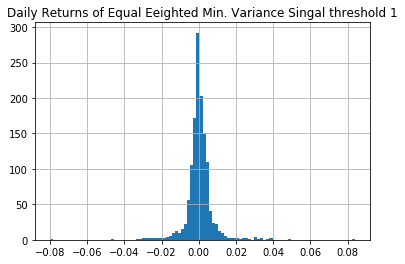

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2676.
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          9.41e-321
Time:                        11:49:36   Log-Likelihood:                 5347.8
No. Observations:                1332   AIC:                        -1.069e+04
Df Residuals:                    1330   BIC:                        -1.068e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000

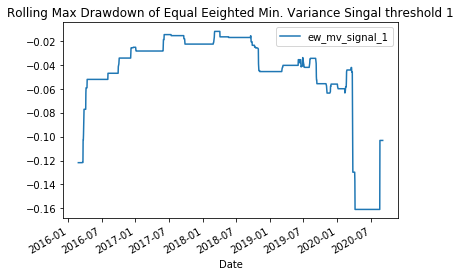

max dd: -0.1609546235473973
IR
Date
2015-12-31         NaN
2016-12-31   -2.065880
2017-12-31    8.148380
2018-12-31    1.375555
2019-12-31    4.792119
2020-12-31   -4.118508
Freq: A-DEC, dtype: float64
1.6263331937369259
Profit       1.345737
Alpha        0.000304
Beta        -0.569532
Daily Vol    0.007581
MaxDD       -0.160955
IR           1.626333
dtype: float64


Profit       1.345737
Alpha        0.000304
Beta        -0.569532
Daily Vol    0.007581
MaxDD       -0.160955
IR           1.626333
dtype: float64

In [34]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_1'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 1")

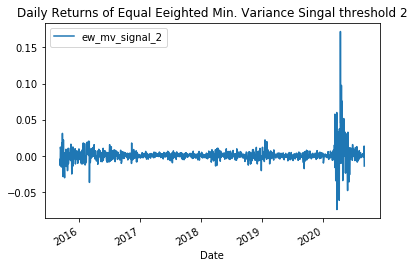

Ending Equity/ Profitability
Date
2020-09-04    2.510318
Name: ew_mv_signal_2, dtype: float64
count    1332.000000
mean        0.000739
std         0.009905
min        -0.073983
25%        -0.001944
50%         0.000112
75%         0.003010
max         0.171777
Name: ew_mv_signal_2, dtype: float64


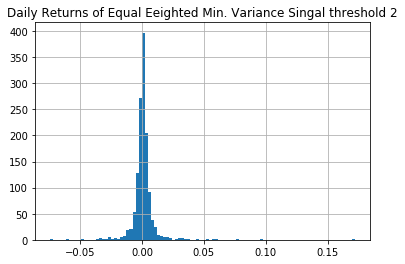

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     115.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):           7.94e-26
Time:                        11:49:38   Log-Likelihood:                 4312.5
No. Observations:                1332   AIC:                            -8621.
Df Residuals:                    1330   BIC:                            -8611.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000

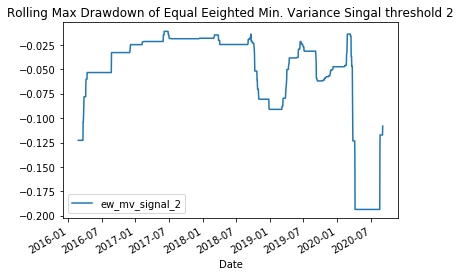

max dd: -0.1935219679779857
IR
Date
2015-12-31         NaN
2016-12-31   -1.743666
2017-12-31    7.114571
2018-12-31    2.338978
2019-12-31    4.440041
2020-12-31   -0.548082
Freq: A-DEC, dtype: float64
2.3203685219480636
Profit       2.510318
Alpha        0.000762
Beta        -0.257023
Daily Vol    0.009905
MaxDD       -0.193522
IR           2.320369
dtype: float64


Profit       2.510318
Alpha        0.000762
Beta        -0.257023
Daily Vol    0.009905
MaxDD       -0.193522
IR           2.320369
dtype: float64

In [35]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_2'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 2")

In [36]:
def simple_mv_backtester(bt_signal_df, ret_df, min_periods=20, rules=1.645):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).dropna(how='all', axis=1).fillna(0)
    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    
    bt_ret_df = ret_df*bt_holdings
    bt_ret_df = ret_df.replace(-0,0)

    
    ## to avoid sigular matrix error due to zero prices returns, adding tiny tiny nois to the covariance matrix
    noised_bt_ret_df = bt_ret_df+0.00000001*np.random.rand(*bt_ret_df.shape)
    noised_bt_ret_df = noised_bt_ret_df.dropna(how='all', axis=1).fillna(0)
    cov_df = noised_bt_ret_df.expanding( min_periods=min_periods).cov().dropna(axis=0) # window=min_periods,
    

    w_MV = cov_df.groupby(level=0, axis=0).apply(compute_MV_weights).apply(pd.Series)
    
    w_MV.columns = cov_df.columns
    
    bt_port_ret = (bt_ret_df.mul(w_MV, axis='index').fillna(0)).sum(axis=1) 
    bt_mv_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_mv_eq_curve
    
    
    

In [37]:
mv_port_ret_2, mv_eq_curv_2 = simple_mv_backtester(combined_signal, ret_df, rules=2)


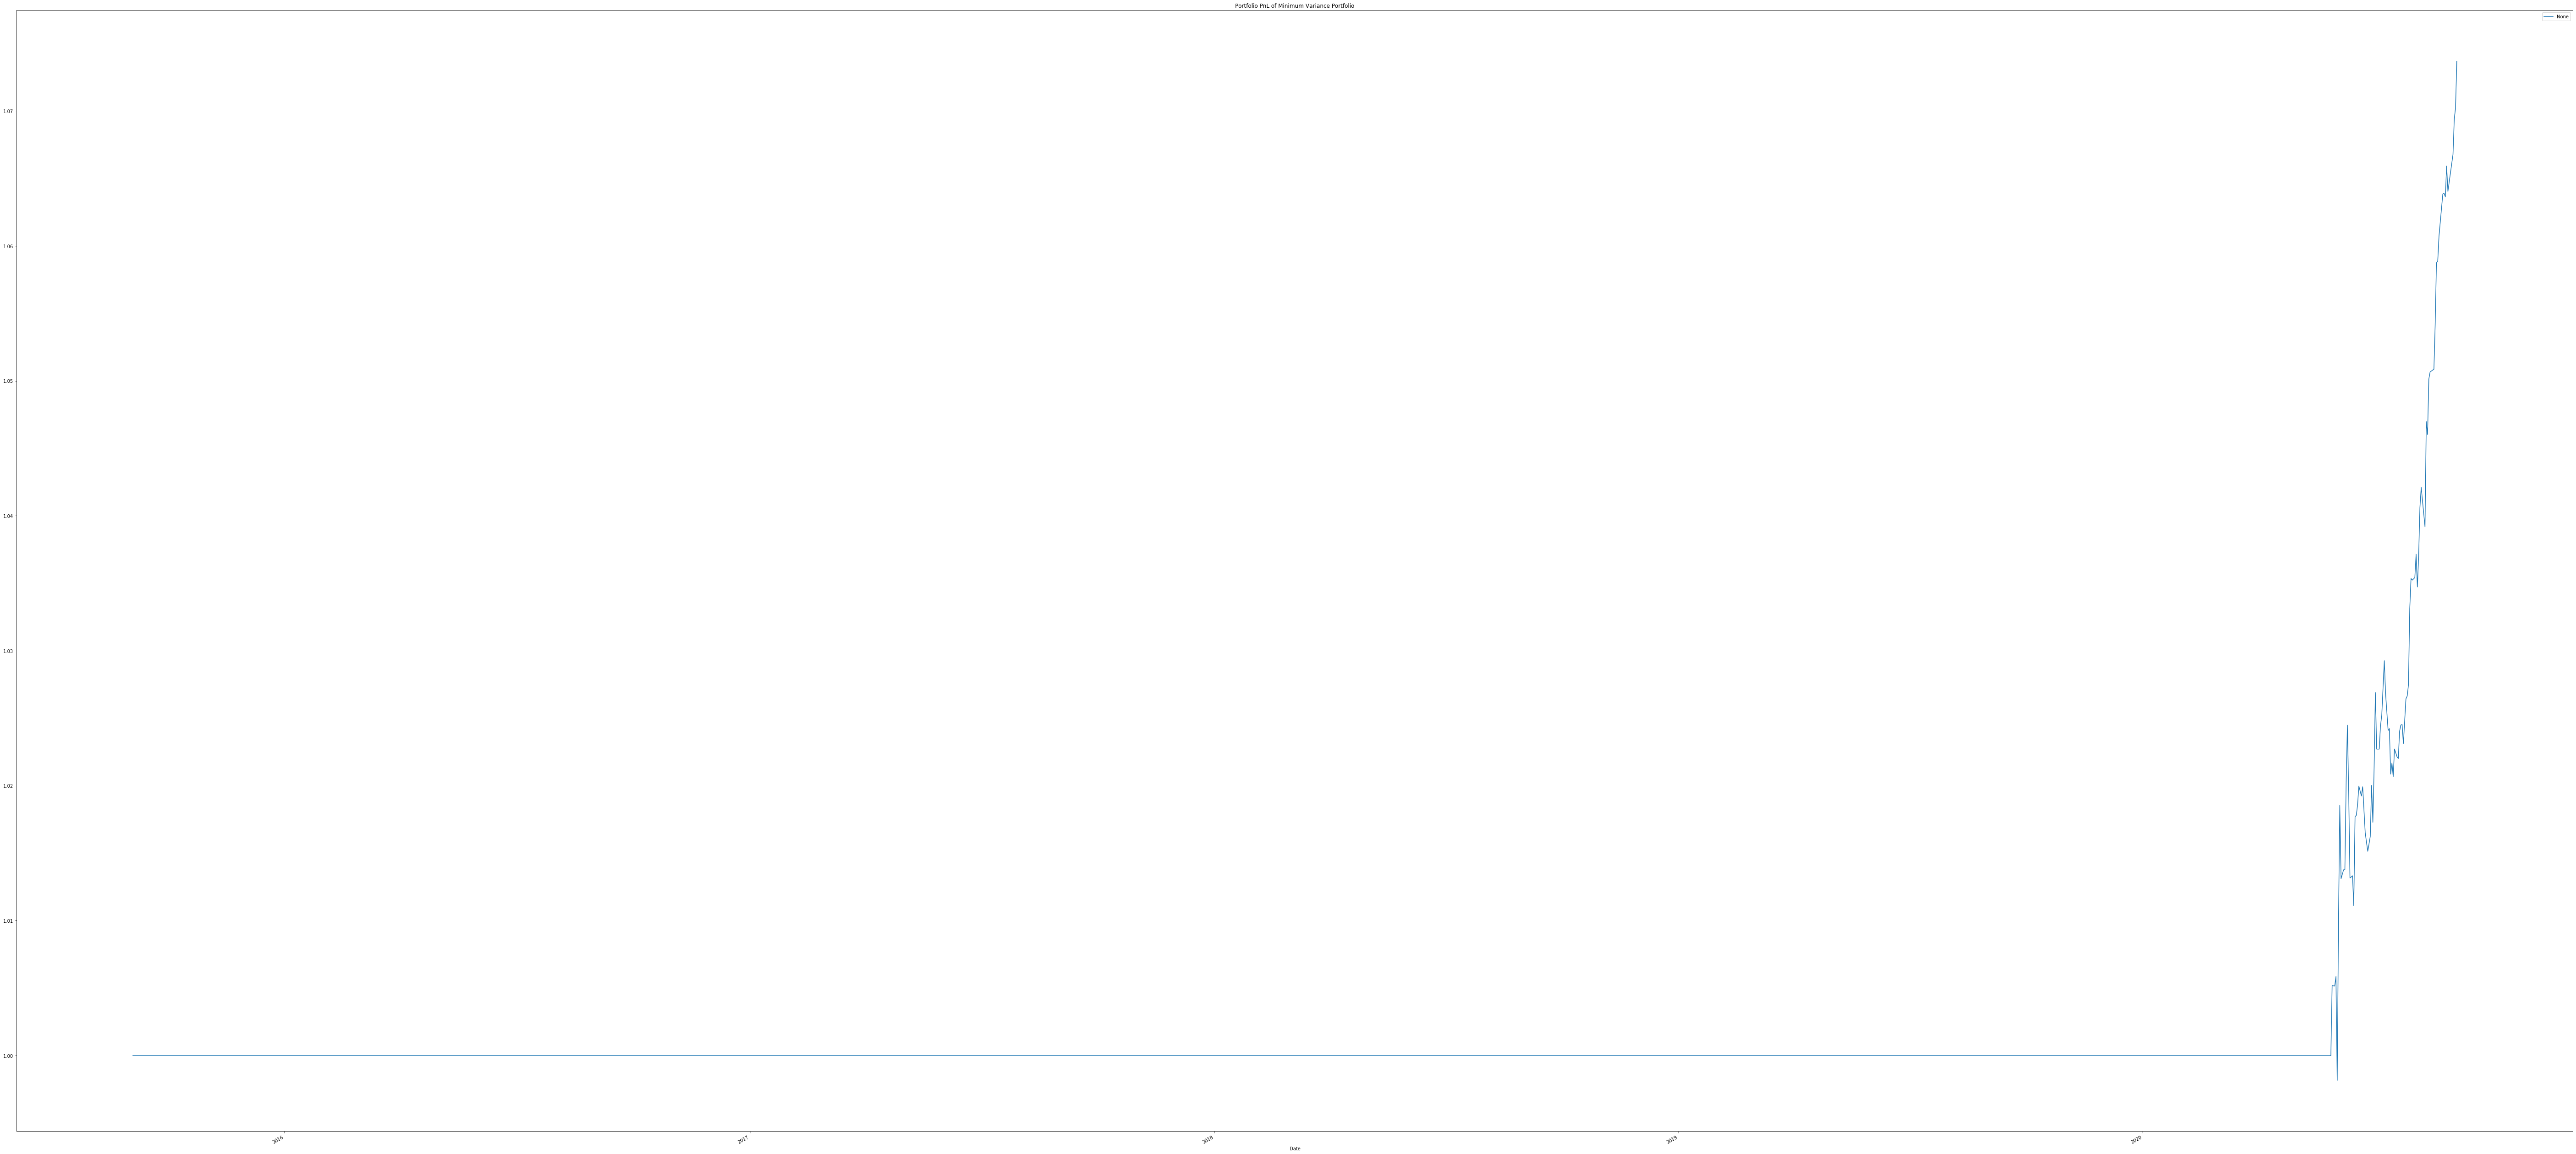

In [38]:
mv_eq_curv_2.plot(figsize=(100,50), legend=True,title="Portfolio PnL of Minimum Variance Portfolio")
plt.show()
plt.close()

In [39]:
ew_eq_curve_20_50_150['MV_port_2'] = mv_eq_curv_2

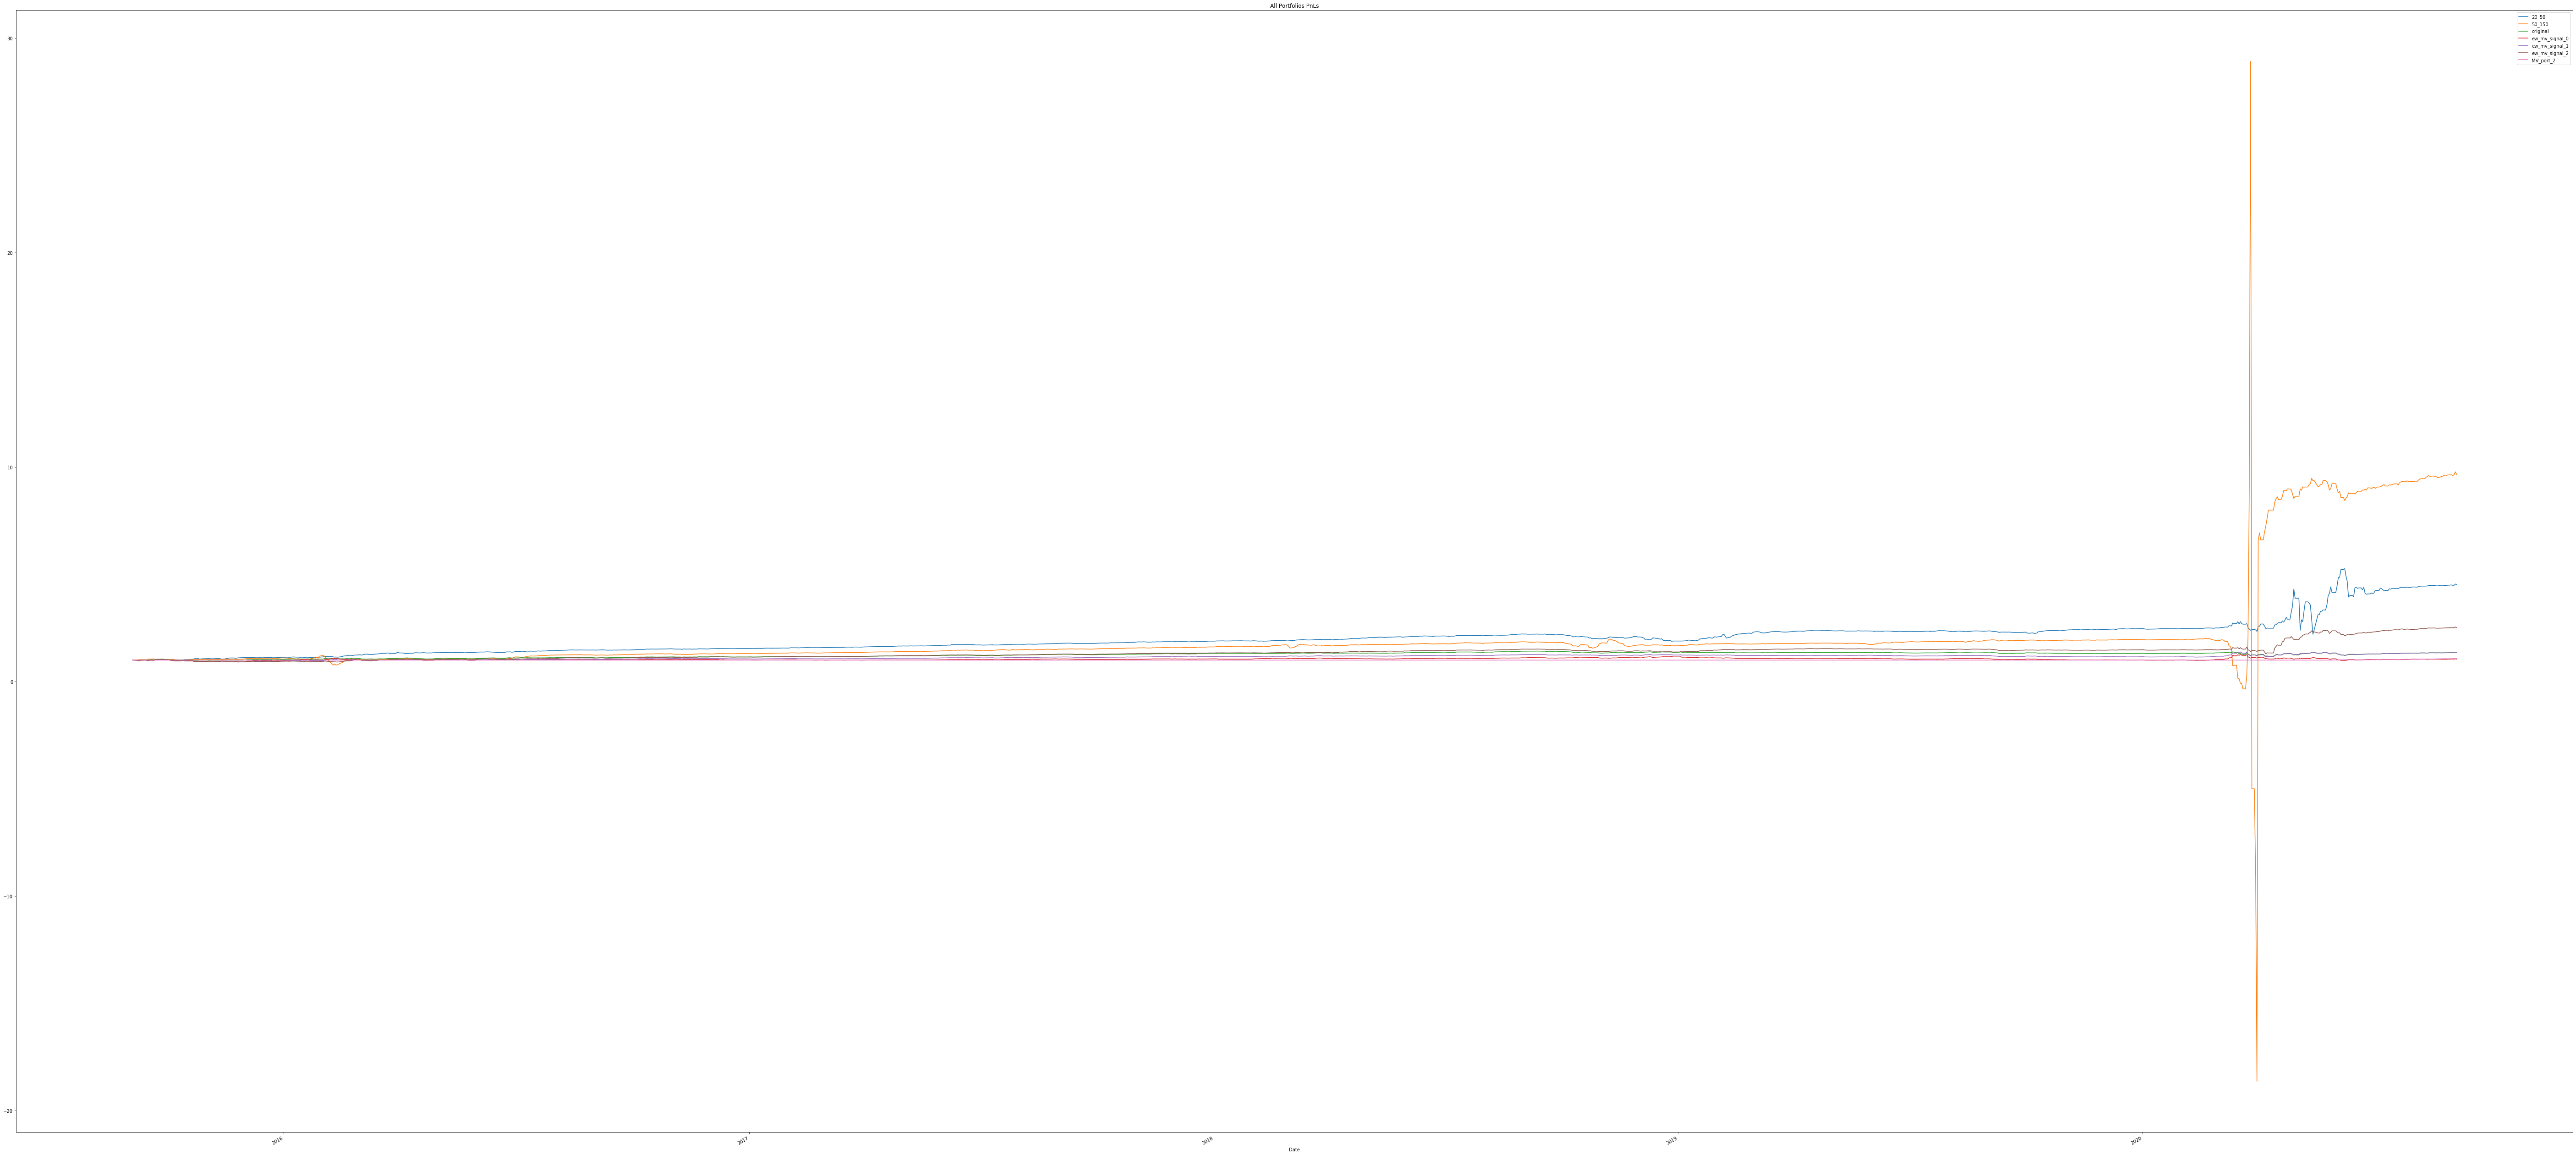

In [40]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True,title="All Portfolios PnLs")
plt.show()
plt.close()

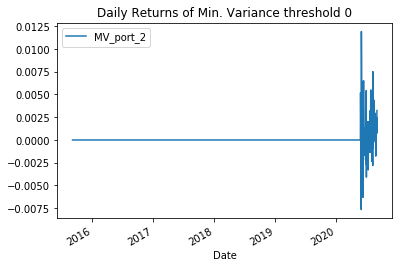

Ending Equity/ Profitability
Date
2020-09-04    1.073674
Name: MV_port_2, dtype: float64
count    1.332000e+03
mean     5.369034e-05
std      8.019310e-04
min     -7.643076e-03
25%     -7.655429e-10
50%     -3.908268e-11
75%      7.201248e-10
max      1.191615e-02
Name: MV_port_2, dtype: float64


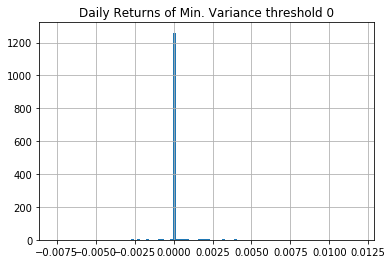

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.182
Date:                Fri, 04 Sep 2020   Prob (F-statistic):              0.140
Time:                        11:53:38   Log-Likelihood:                 7606.7
No. Observations:                1332   AIC:                        -1.521e+04
Df Residuals:                    1330   BIC:                        -1.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.342e-05    2.2e-05

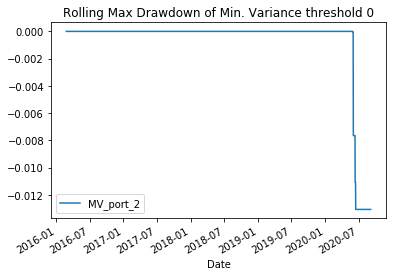

max dd: -0.013054700646637829
IR
Date
2015-12-31             NaN
2016-12-31   -1.603932e+05
2017-12-31    5.471571e+04
2018-12-31   -1.350920e+07
2019-12-31    1.362398e+07
2020-12-31   -1.244439e+01
Freq: A-DEC, dtype: float64
1818.355593563634
Profit          1.073674
Alpha           0.000053
Beta            0.002983
Daily Vol       0.000802
MaxDD          -0.013055
IR           1818.355594
dtype: float64


Profit          1.073674
Alpha           0.000053
Beta            0.002983
Daily Vol       0.000802
MaxDD          -0.013055
IR           1818.355594
dtype: float64

In [41]:
performance_analysis(ew_eq_curve_20_50_150['MV_port_2'], (port_ret['Short'] + 1).cumprod(), port_name="Min. Variance threshold 0")